# Cross-matching entre catalogues X et optique

Plus précisément entre eRASS1 (Bulbul et al. 2024) et DESI Legacy Imaging Surveys (Wen and Han 2024)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import math
import scipy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.cosmology import Planck13
import pickle
import os
import random

In [69]:
from gem_astmatch_modified import match_celestial_objects_list_deg,match_celestial_objects,create_skycoord_from_fits,do_celest_match_fits   

# Import catalogues

Fonction pour passer de .fit à un dataframe (REMARQUE : Le programme ne semble pas fonctionner pour certains fits binary → dans le doute télécharger des fits ascii) : 

In [70]:
#Description des tables :
# catass -  est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen 
# dtass - contient juste l'information d'association, pour l'objet la plus proche (en angle) 
# dtassall - contient l'information d'association , uniquement pour les objets X ayant été associés à un objet optique, et tous les objets qui passent le critère d'association (angulaire et en redshift) 

'''
#Ne fonctionnait car le cgicher étaut un fits binary
def fits_to_dataframe_catass(fits_file):
    with fits.open(fits_file) as hdul:
        catass = hdul[1].data 
        catass_df = pd.DataFrame(catass)

        dtass_binary = hdul[2].data 
        dtass = Table(dtass_binary) 
        dtass.write('dtass.fits', overwrite=True, format='ascii') 
        dtass_df = pd.DataFrame(dtass)

        dtassall = hdul[3].data 
        dtassall_df = pd.DataFrame(dtassall)
    return catass_df, dtass_df, dtassall_df'''

# Transforme certaines extensions d'un fichier FITS en un fichier FITS ASCII
def fits_binary_to_fits_ascii_list(fits_file, liste_indexes, name_list):  # liste_indexes indique les extensions du fits à lire ; name_list correspond aux noms des fichiers de sortie
    for x, x_name in zip(liste_indexes, name_list):  # Use zip to iterate over both lists simultaneously
        with fits.open(fits_file) as hdul:
            data = hdul[x].data
            data_table = Table(data)  # Convertit le tableau binaire en un tableau astropy
            data_table.write(x_name, overwrite=True, format='ascii')  # Écrit le tableau dans un fichier FITS ASCII

#Transforme un FITS ascii en un DataFrame pandas
def ascii_to_dataframe(ascii_file, delimiter=' '):
    data_df = pd.read_csv(ascii_file, delimiter=delimiter)
    return data_df

# Transfome la première extension d'un fichier FITS en un DataFrame pandas
def fits_to_dataframe(fits_file):
    with fits.open(fits_file) as hdul:
        data = hdul[1].data 
        data_df = pd.DataFrame(data)
    return data_df



# Transforme certaines extensions d'un fichier FITS en un DataFrame pandas(→ pour que ça fonctionne, il faut un fits ascii et pas un fits binaire)
def fits_to_dataframe_list(fits_file, liste_indexes):  # liste_indexes indique les extensions du fits à lire
    df_list = []  # Initialize the list outside the loop
    with fits.open(fits_file) as hdul:
        for x in liste_indexes:
            data = hdul[x].data  # Select the data in the xth extension
            df_list.append(pd.DataFrame(data))
            print(df_list)
    return df_list  # Return the entire list of DataFrames

#def fits_binary_to_fits_ascii(fits_file):

On précise le chemin menant à chacun des catalogues pour ensuite les importer

In [71]:
path_X = 'clxC.fits' #la première table est la table eRosita de départ, enrichie avec des informations d'association avec SDSS-Wen
name_X = 'eROSITA_BULBUL_2024'

path_opt = '../DESI_eRass/DESI_Legacy_Wen_2024.fit'
name_opt = 'Wen_2024_DESI_Legacy'

In [72]:
'''clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!
fits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !''' 

"clx_catass_df = fits_to_dataframe(path_X) # !!! clx_dtass_df, clx_dtassall_df → problème de BigEndian → sans doute que les fits sont binary et non pas ascii !!!\nfits_binary_to_fits_ascii_list(path_X,[1,2,3],['clxC_catass.ascii','clxC_dtass.ascii','clxC_dtassall.ascii']) #Change les fichiers dans le dossier !"

In [73]:
if path_X == 'clxB.fits':
    clx_catass_df = ascii_to_dataframe('clxB_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxB_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxB_dtassall.ascii')  

elif path_X == 'clxC.fits':
    clx_catass_df = ascii_to_dataframe('clxC_catass.ascii')
    clx_dtass_df = ascii_to_dataframe('clxC_dtass.ascii') 
    clx_dtassall_df = ascii_to_dataframe('clxC_dtassall.ascii')

In [74]:
# On veut récupérer la table Erosita de départ que Reza a utilisé → Ezra Bulbul 2024
columns_to_exclude = ['idm', 'asscnt','idass','dstass','delz','maxassdist','zph','rmag','r200','N200']
table_X = clx_catass_df.drop(columns=columns_to_exclude) # Pour l'instant, table eRosita
table_X


_RAJ2000   _DEJ2000                     Name     RAJ2000    DEJ2000  \
0        0.021730 -38.624903  1eRASS J000005.2-383729    0.021730 -38.624903   
1        0.089191 -82.831715  1eRASS J000021.4-824954    0.089191 -82.831715   
2        0.129422 -50.151013  1eRASS J000031.0-500903    0.129422 -50.151013   
3        0.132712 -63.025286  1eRASS J000031.8-630131    0.132712 -63.025286   
4        0.189080 -46.394874  1eRASS J000045.3-462341    0.189080 -46.394874   
...           ...        ...                      ...         ...        ...   
12241  359.741833 -60.612333  1eRASS J235858.0-603644  359.741833 -60.612333   
12242  359.799123 -55.296727  1eRASS J235911.7-551748  359.799123 -55.296727   
12243  359.864701 -34.306012  1eRASS J235927.5-341821  359.864701 -34.306012   
12244  359.980381 -44.205215  1eRASS J235955.2-441218  359.980381 -44.205215   
12245  359.983837 -39.473995  1eRASS J235956.1-392826  359.983837 -39.473995   

              Exp   zBest  e_zBest        zType  pcont  ...  CTS300kpc  \
0       94.800003  0.3153   0.0079      photo_z  0.006  ...       33.4   
1      184.199997  0.0891   0.0002    cg_spec_z  0.000  ...      128.8   
2      117.300003  0.0681   0.0002    cg_spec_z  0.218  ...       29.9   
3      139.600006  0.2448   0.0058      photo_z  0.005  ...       24.3   
4      109.500000  0.0925   0.0004    cg_spec_z  0.715  ...       20.0   
...           ...     ...      ...          ...    ...  ...        ...   
12241  142.500000  0.1052   0.0064      photo_z  0.000  ...      204.7   
12242  130.800003  0.2137   0.0063      photo_z  0.506  ...       15.3   
12243   87.500000  0.1138   0.0004  spec_z_boot  0.003  ...       42.6   
12244   98.099998  0.5797   0.0117      photo_z  0.982  ...       12.3   
12245   93.000000  0.1024   0.0004    cg_spec_z  0.000  ...      110.6   

       CTS500     F500     L500    KT     Mgas500   YX500       M500  Fgas500  \
0        48.2   47.110  140.172  1.90  279.160004  553.19  36.070000    0.075   
1       189.5   98.355   24.747   NaN  111.919998    0.00  16.990000    0.065   
2        30.3   23.991    2.862  1.79    1.920000    9.34   3.630000    0.009   
3        49.6   33.228   57.877   NaN  171.949997    0.00  22.040001    0.076   
4        20.8   16.818    3.996  0.96    6.400000   11.17   3.780000    0.019   
...       ...      ...      ...   ...         ...     ...        ...      ...   
12241   506.8  337.065   97.721   NaN  358.950012    0.00  38.669998    0.093   
12242    15.8   11.402   15.028   NaN    5.590000    0.00   8.150000    0.008   
12243    62.5   62.778   22.350   NaN   81.230003    0.00  14.110000    0.054   
12244    13.4   12.342  165.113   NaN   41.310001    0.00  25.920000    0.020   
12245   188.0  192.414   52.418  4.18  192.529999  793.02  27.010000    0.071   

       R500  
0       971  
1       819  
2       493  
3       846  
4       495  
...     ...  
12241  1071  
12242   614  
12243   763  
12244   785  
12245   951  

[12246 rows x 22 columns]

REMARQUE : M500 dans la table_X est en $10^{13} M_{SUN}$.

In [ ]:
table_optique = fits_to_dataframe(path_opt)


In [ ]:
table_optique


_RAJ2000  _DEJ2000       ID n_Name              Name    RAJ2000  \
0          0.00046 -37.47628        1         J000000.1-372835    0.00046   
1          0.00135 -56.58835        2    WH-  J000000.3-563518    0.00135   
2          0.00172 -39.32369        3         J000000.4-391925    0.00172   
3          0.00201   2.31980        4         J000000.5+021911    0.00201   
4          0.00260 -59.01297        5    WH-  J000000.6-590047    0.00260   
...            ...       ...      ...    ...               ...        ...   
1581174  359.99667   4.99211  1581175    WH-  J235959.2+045932  359.99667   
1581175  359.99680  21.78514  1581176         J235959.2+214707  359.99680   
1581176  359.99817  10.04951  1581177         J235959.6+100258  359.99817   
1581177  359.99847  -6.34469  1581178    WH-  J235959.6-062041  359.99847   
1581178  359.99902   7.67085  1581179         J235959.8+074015  359.99902   

          DEJ2000     zCl  f_zCl    zmag  ...  logMs   r500  lam500  M500  \
0       -37.47628  0.1364      0  15.377  ...  11.49  0.766   25.79  1.17   
1       -56.58835  0.1957      0  15.712  ...  11.70  0.625   23.24  1.06   
2       -39.32369  0.3580      0  17.713  ...  11.41  0.526   15.90  0.73   
3         2.31980  0.4282      1  18.043  ...  11.55  0.612   23.40  1.07   
4       -59.01297  0.1380      0  14.993  ...  11.69  0.606   15.71  0.73   
...           ...     ...    ...     ...  ...    ...    ...     ...   ...   
1581174   4.99211  0.5948      0  19.184  ...  11.37  0.420   10.99  0.51   
1581175  21.78514  0.4050      1  17.259  ...  11.78  0.658   31.73  1.43   
1581176  10.04951  0.7919      0  18.904  ...  11.88  0.621   33.23  1.50   
1581177  -6.34469  1.0333      0  20.952  ...  11.18  0.439   13.12  0.61   
1581178   7.67085  0.6633      0  19.532  ...  11.27  0.542   14.02  0.65   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0          14    0.0      0.0      1  WHY18            1  
1           7    0.0      0.0      1                   2  
2           7    0.0      0.0      1  Y21              3  
3          13    0.0      0.0      1  redMaPPer        4  
4           7    0.0      0.0      1                   5  
...       ...    ...      ...    ...        ...      ...  
1581174     6    0.0      0.0      2             1581175  
1581175     9    0.0      0.0      2  WHL        1581176  
1581176     8    0.0      0.0      2  CFSFDP     1581177  
1581177     6    0.0      0.0      2             1581178  
1581178     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 21 columns]

REMARQUE POUR DESI Legacy Imaging Surveys WEN 2024 : M500 est en $10^{14} M_{SUN}$, on convertit donc cette colonne en $10^{13} M_{SUN}$,

In [ ]:
# SEULEMENT SI WEN_2024 DESI LEGACY 

M500_opt_13 = table_optique['M500']*10
table_optique['M500'] = M500_opt_13


In [ ]:
# On calcule les coordonnées galactiques
'''# objets X 
raj2000_x_list = table_X['RAJ2000'].tolist()
dej2000_x_list = table_X['DEJ2000'].tolist()
j2000_coords_x = SkyCoord(raj2000_x_list, dej2000_x_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_x = j2000_coords_x.galactic # conversion J2000 -> galactique

# objets optiques 
raj2000_opt_list = table_optique['RAJ2000'].tolist()
dej2000_opt_list = table_optique['DEJ2000'].tolist()
j2000_coords_opt = SkyCoord(raj2000_opt_list, dej2000_opt_list, unit=(u.degree, u.degree), frame='icrs')
galactic_coords_opt = j2000_coords_opt.galactic # conversion J2000 -> galactique

#On les exporte dans le dossier ../DESI_eRass/'''

output_folder = "../DESI_eRass/"  

'''
# Save 'galactic_coords_x'
with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_x, file)

# Save 'galactic_coords_opt'
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:
    pickle.dump(galactic_coords_opt, file)'''

"\n# Save 'galactic_coords_x'\nwith open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_x, file)\n\n# Save 'galactic_coords_opt'\nwith open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'wb') as file:\n    pickle.dump(galactic_coords_opt, file)"

In [ ]:
# On récupère les coordonnées galactiques et on les ajoute aux tables

with open(os.path.join(output_folder, 'galactic_coords_x.pkl'), 'rb') as file:
    galactic_coords_x = pickle.load(file)
with open(os.path.join(output_folder, 'galactic_coords_opt.pkl'), 'rb') as file:
    galactic_coords_opt = pickle.load(file)


table_optique['glon'] = galactic_coords_opt.l.deg ; table_optique['glat'] = galactic_coords_opt.b.deg
table_optique = table_optique[['glat'] + [col for col in table_optique.columns if col != 'glat']]
table_optique = table_optique[['glon'] + [col for col in table_optique.columns if col != 'glon']]

table_X['glon'] = galactic_coords_x.l.deg ; table_X['glat'] = galactic_coords_x.b.deg
table_X = table_X[['glat'] + [col for col in table_X.columns if col != 'glat']]
table_X = table_X[['glon'] + [col for col in table_X.columns if col != 'glon']]

In [ ]:
table_X

glon       glat    _RAJ2000   _DEJ2000                     Name  \
0      342.749448 -74.271284    0.021730 -38.624903  1eRASS J000005.2-383729   
1      304.840936 -34.106231    0.089191 -82.831715  1eRASS J000021.4-824954   
2      322.452378 -65.003242    0.129422 -50.151013  1eRASS J000031.0-500903   
3      312.522364 -53.144800    0.132712 -63.025286  1eRASS J000031.8-630131   
4      327.067389 -68.286560    0.189080 -46.394874  1eRASS J000045.3-462341   
...           ...        ...         ...        ...                      ...   
12241  314.228009 -55.350263  359.741833 -60.612333  1eRASS J235858.0-603644   
12242  317.972769 -60.279763  359.799123 -55.296727  1eRASS J235911.7-551748   
12243  357.004161 -76.739220  359.864701 -34.306012  1eRASS J235927.5-341821   
12244  330.823690 -70.028243  359.980381 -44.205215  1eRASS J235955.2-441218   
12245  340.618742 -73.658436  359.983837 -39.473995  1eRASS J235956.1-392826   

          RAJ2000    DEJ2000         Exp   zBest  e_zBest  ... CTS300kpc  \
0        0.021730 -38.624903   94.800003  0.3153   0.0079  ...      33.4   
1        0.089191 -82.831715  184.199997  0.0891   0.0002  ...     128.8   
2        0.129422 -50.151013  117.300003  0.0681   0.0002  ...      29.9   
3        0.132712 -63.025286  139.600006  0.2448   0.0058  ...      24.3   
4        0.189080 -46.394874  109.500000  0.0925   0.0004  ...      20.0   
...           ...        ...         ...     ...      ...  ...       ...   
12241  359.741833 -60.612333  142.500000  0.1052   0.0064  ...     204.7   
12242  359.799123 -55.296727  130.800003  0.2137   0.0063  ...      15.3   
12243  359.864701 -34.306012   87.500000  0.1138   0.0004  ...      42.6   
12244  359.980381 -44.205215   98.099998  0.5797   0.0117  ...      12.3   
12245  359.983837 -39.473995   93.000000  0.1024   0.0004  ...     110.6   

       CTS500     F500     L500    KT     Mgas500   YX500       M500  Fgas500  \
0        48.2   47.110  140.172  1.90  279.160004  553.19  36.070000    0.075   
1       189.5   98.355   24.747   NaN  111.919998    0.00  16.990000    0.065   
2        30.3   23.991    2.862  1.79    1.920000    9.34   3.630000    0.009   
3        49.6   33.228   57.877   NaN  171.949997    0.00  22.040001    0.076   
4        20.8   16.818    3.996  0.96    6.400000   11.17   3.780000    0.019   
...       ...      ...      ...   ...         ...     ...        ...      ...   
12241   506.8  337.065   97.721   NaN  358.950012    0.00  38.669998    0.093   
12242    15.8   11.402   15.028   NaN    5.590000    0.00   8.150000    0.008   
12243    62.5   62.778   22.350   NaN   81.230003    0.00  14.110000    0.054   
12244    13.4   12.342  165.113   NaN   41.310001    0.00  25.920000    0.020   
12245   188.0  192.414   52.418  4.18  192.529999  793.02  27.010000    0.071   

       R500  
0       971  
1       819  
2       493  
3       846  
4       495  
...     ...  
12241  1071  
12242   614  
12243   763  
12244   785  
12245   951  

[12246 rows x 24 columns]

In [ ]:
table_optique

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
0        346.037516 -75.021144    0.00046 -37.47628        1          
1        316.752759 -59.138458    0.00135 -56.58835        2    WH-   
2        340.962781 -73.774528    0.00172 -39.32369        3          
3         98.087140 -58.049446    0.00201   2.31980        4          
4        315.038146 -56.890161    0.00260 -59.01297        5    WH-   
...             ...        ...        ...       ...      ...    ...   
1581174   99.846285 -55.556496  359.99667   4.99211  1581175    WH-   
1581175  107.386200 -39.528434  359.99680  21.78514  1581176          
1581176  102.648089 -50.784985  359.99817  10.04951  1581177          
1581177   90.146970 -65.886375  359.99847  -6.34469  1581178    WH-   
1581178  101.410122 -53.037823  359.99902   7.67085  1581179          

                     Name    RAJ2000   DEJ2000     zCl  ...  logMs   r500  \
0        J000000.1-372835    0.00046 -37.47628  0.1364  ...  11.49  0.766   
1        J000000.3-563518    0.00135 -56.58835  0.1957  ...  11.70  0.625   
2        J000000.4-391925    0.00172 -39.32369  0.3580  ...  11.41  0.526   
3        J000000.5+021911    0.00201   2.31980  0.4282  ...  11.55  0.612   
4        J000000.6-590047    0.00260 -59.01297  0.1380  ...  11.69  0.606   
...                   ...        ...       ...     ...  ...    ...    ...   
1581174  J235959.2+045932  359.99667   4.99211  0.5948  ...  11.37  0.420   
1581175  J235959.2+214707  359.99680  21.78514  0.4050  ...  11.78  0.658   
1581176  J235959.6+100258  359.99817  10.04951  0.7919  ...  11.88  0.621   
1581177  J235959.6-062041  359.99847  -6.34469  1.0333  ...  11.18  0.439   
1581178  J235959.8+074015  359.99902   7.67085  0.6633  ...  11.27  0.542   

         lam500  M500  Ngal  Gamma  e_Gamma  imag_        Cat    recno  
0         25.79  11.7    14    0.0      0.0      1  WHY18            1  
1         23.24  10.6     7    0.0      0.0      1                   2  
2         15.90   7.3     7    0.0      0.0      1  Y21              3  
3         23.40  10.7    13    0.0      0.0      1  redMaPPer        4  
4         15.71   7.3     7    0.0      0.0      1                   5  
...         ...   ...   ...    ...      ...    ...        ...      ...  
1581174   10.99   5.1     6    0.0      0.0      2             1581175  
1581175   31.73  14.3     9    0.0      0.0      2  WHL        1581176  
1581176   33.23  15.0     8    0.0      0.0      2  CFSFDP     1581177  
1581177   13.12   6.1     6    0.0      0.0      2             1581178  
1581178   14.02   6.5     9    0.0      0.0      2  Y21        1581179  

[1581179 rows x 23 columns]

# Visualisation zones communes et sélection

On va notamment chercher à quantifier l'efficacité de l'association, c'est à dire le rapport d'amas X associés sur le rapport d'amas X total : cependant pour que cela ait un intérêt, il nous faut auparavant sélectionner les objets situés dans les footprint communes aux objets X et optique.

## Visualisation (en coordonnées galactiques)

In [ ]:
#Transformation des coordonnées galactiques en listes

X_glon = table_X['glon'].tolist() ; X_glat = table_X['glat'].tolist()

opt_glon = table_optique['glon'].tolist() ; opt_glat = table_optique['glat'].tolist()


"with open(os.path.join('Footprint_X_optical_clusters_galactic_coordinates.pkl'), 'wb') as file:\n    pickle.dump(fig, file)"

C:\Users\ED282972\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ED282972\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


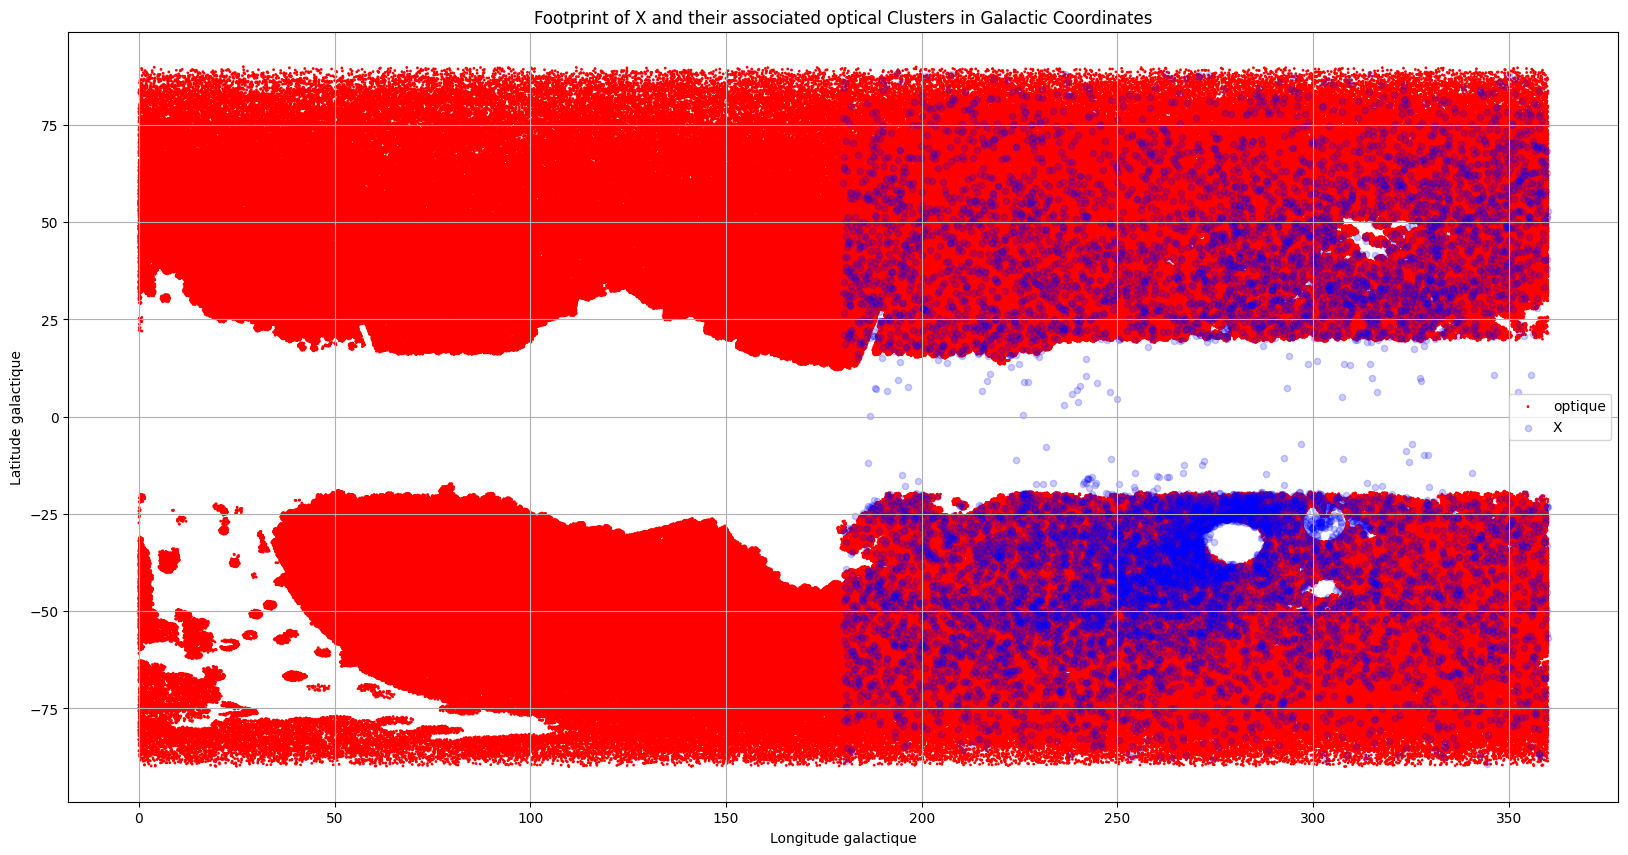

In [ ]:
fig = plt.figure(figsize=(20, 10))
'''ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)'''
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)


ax_projection_opt_all.scatter(opt_glon, opt_glat,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_all.grid(True)
ax_projection_opt_all.set_xlabel("Longitude galactique")
ax_projection_opt_all.set_ylabel("Latitude galactique")

ax_projection_X_all.scatter(X_glon, X_glat, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("Longitude galactique")
ax_projection_X_all.set_ylabel("Latitude galactique")


plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates")
plt.legend()

'''with open(os.path.join('Footprint_X_optical_clusters_galactic_coordinates.pkl'), 'wb') as file:
    pickle.dump(fig, file)'''

#plt.savefig(f"Footprint_X_optical_clusters_galactic_coordinates.png", dpi=300)

## Sélection

Grâce au plot précédent, on est en mesure de sélectionner l'entièreté des zones où on retrouve les objets optique et les objets X.

In [ ]:
'''# Load the figure from the file
with open('Footprint_X_optical_clusters_galactic_coordinates.pkl', 'rb') as f:
    loaded_fig = pickle.load(f)'''

"# Load the figure from the file\nwith open('Footprint_X_optical_clusters_galactic_coordinates.pkl', 'rb') as f:\n    loaded_fig = pickle.load(f)"

In [ ]:
# Définition paramètres cercle à exclure
x_center = 303 ; y_center = -27.5 ; radius = 5.8

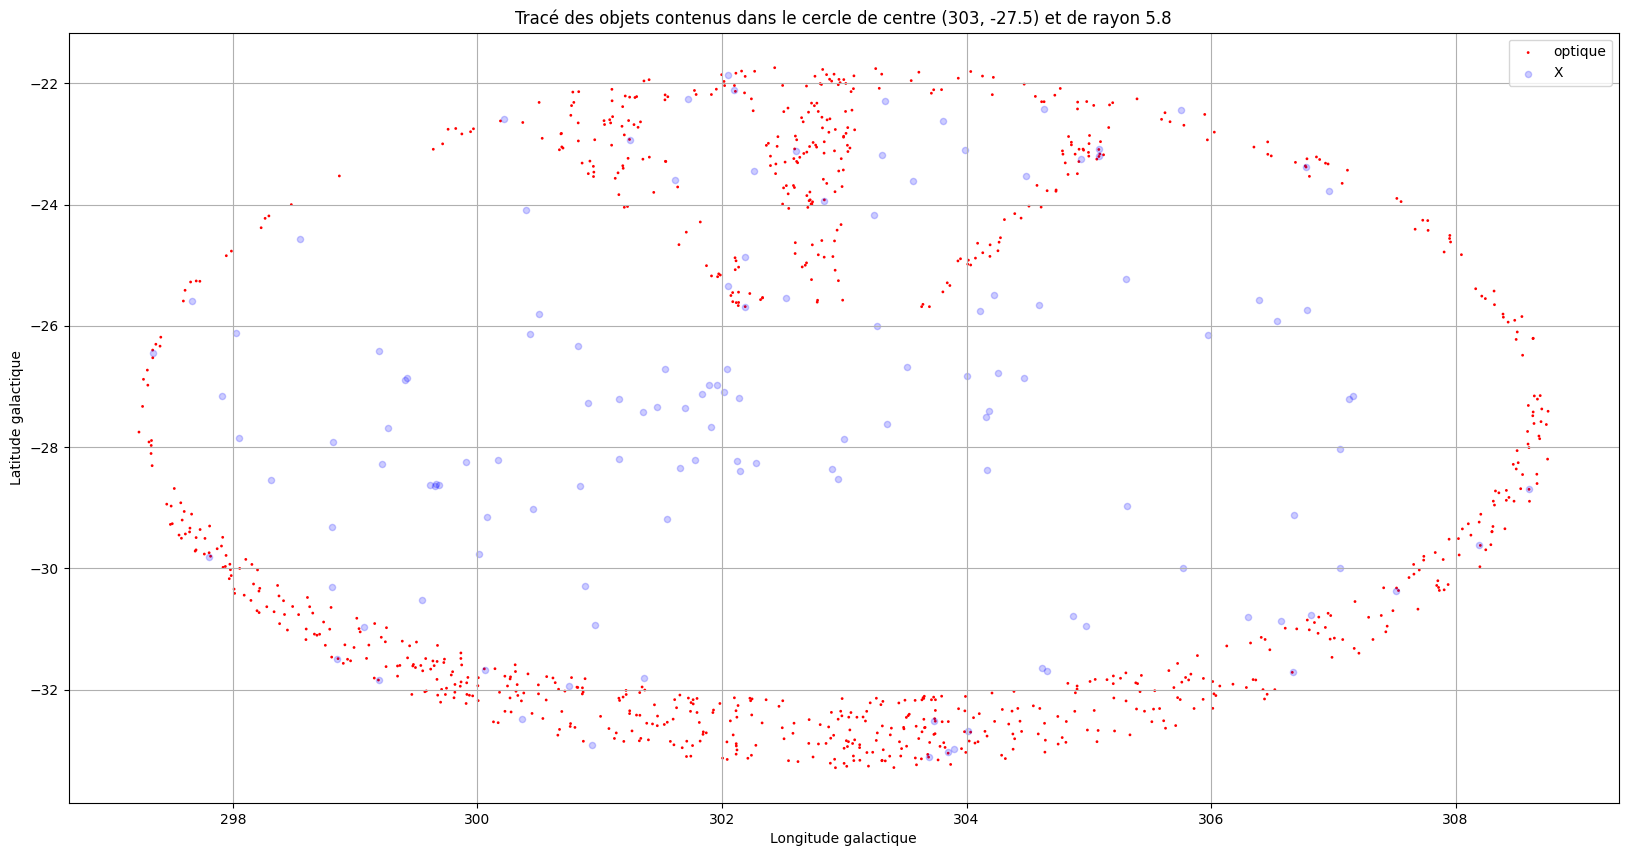

In [ ]:
# On affiche le cercle couvert par les X et non par l'optique afin récupérer ces coordonnée et le supprimer des tables

X_glon_circle = [] ; X_glat_circle = []
opt_glon_circle = [] ; opt_glat_circle = []
for i in range(len(X_glon)):
    if (X_glon[i] - x_center)**2 + (X_glat[i] - y_center)**2 < radius**2:
        X_glon_circle.append(X_glon[i])
        X_glat_circle.append(X_glat[i])
for i in range(len(opt_glon)):
    if (opt_glon[i] - x_center)**2 + (opt_glat[i] - y_center)**2 < radius**2:
        opt_glon_circle.append(opt_glon[i])
        opt_glat_circle.append(opt_glat[i])

fig = plt.figure(figsize=(20, 10))
ax_projection_X_circle = plt.subplot(111)
ax_projection_opt_circle = plt.subplot(111)


ax_projection_opt_circle.scatter(opt_glon_circle, opt_glat_circle,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_circle.grid(True)
ax_projection_opt_circle.set_xlabel("Longitude galactique")
ax_projection_opt_circle.set_ylabel("Latitude galactique")

ax_projection_X_circle.scatter(X_glon_circle, X_glat_circle, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_circle.grid(True)
ax_projection_X_circle.set_xlabel("Longitude galactique")
ax_projection_X_circle.set_ylabel("Latitude galactique")


plt.title(f"Tracé des objets contenus dans le cercle de centre ({x_center}, {y_center}) et de rayon {radius}")
plt.legend()

In [ ]:
# Idem pour la sélection des zones rectangulaires
min_glon = min(X_glon) # eRASS1 ne concerne que l'hémisphère ouest

borne_1_glat = -19
borne_2_glat = 19

Error in callback <function _draw_all_if_interactive at 0x000001F023762C00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

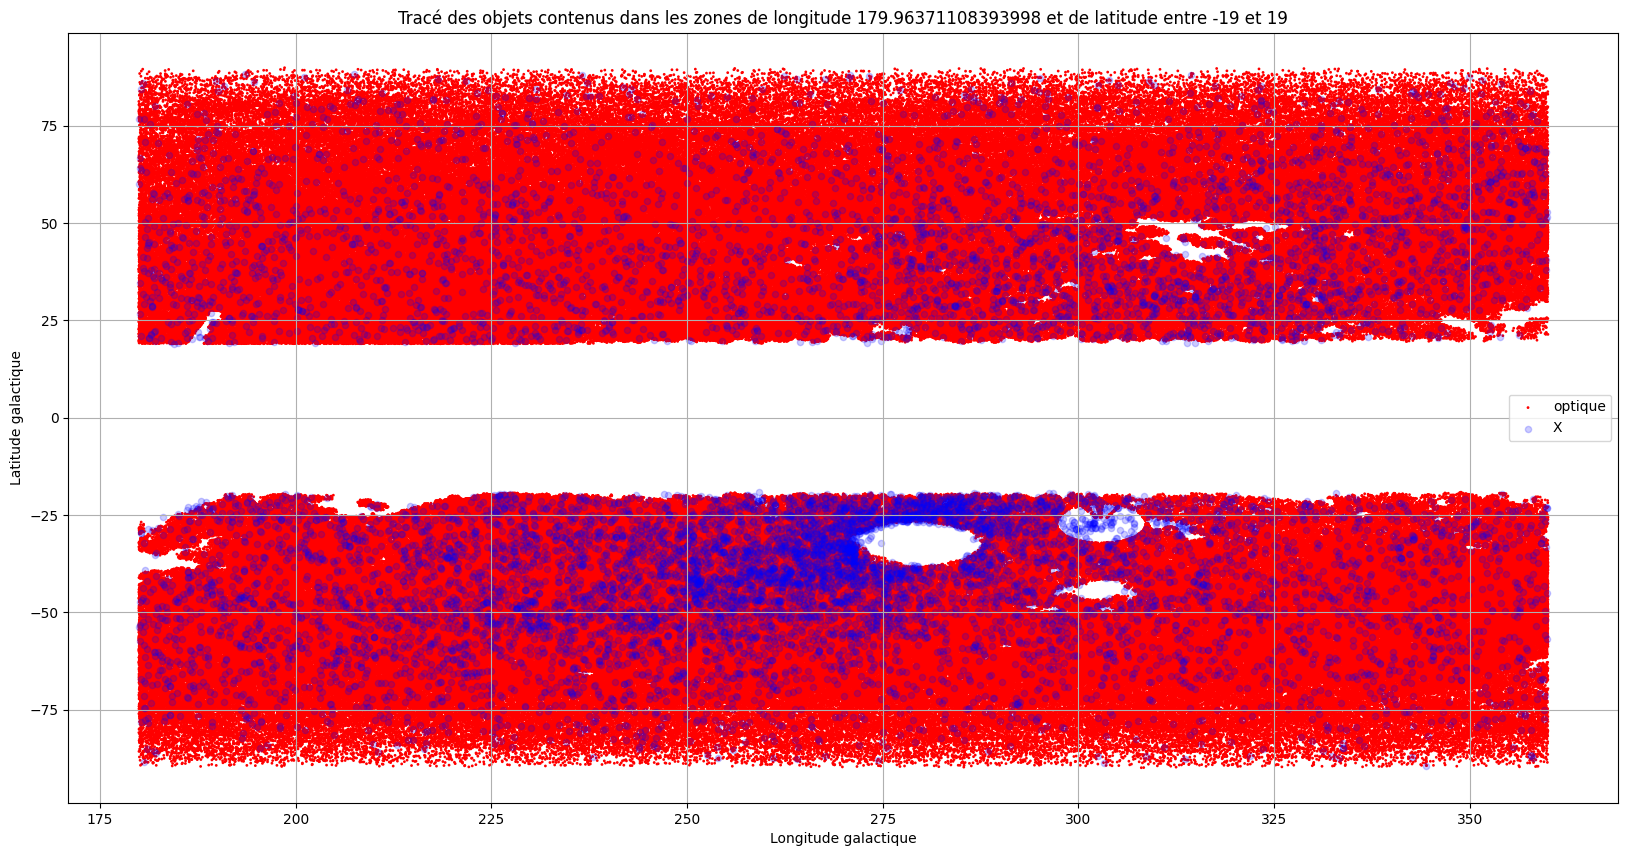

In [ ]:

X_glon_zones = [] ; X_glat_zones = []
opt_glon_zones = [] ; opt_glat_zones = []
for i in range(len(X_glon)):
    if (X_glon[i] > min_glon) and ((X_glat[i] < borne_1_glat) or (X_glat[i] > borne_2_glat)):
        X_glon_zones.append(X_glon[i])
        X_glat_zones.append(X_glat[i])
for i in range(len(opt_glon)):
    if (opt_glon[i] > min_glon) and ((opt_glat[i] < borne_1_glat) or (opt_glat[i] > borne_2_glat)):
        opt_glon_zones.append(opt_glon[i])
        opt_glat_zones.append(opt_glat[i])
fig = plt.figure(figsize=(20, 10))
ax_projection_X_zones = plt.subplot(111)
ax_projection_opt_zones = plt.subplot(111)


ax_projection_opt_zones.scatter(opt_glon_zones, opt_glat_zones,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_zones.grid(True)
ax_projection_opt_zones.set_xlabel("Longitude galactique")
ax_projection_opt_zones.set_ylabel("Latitude galactique")

ax_projection_X_zones.scatter(X_glon_zones, X_glat_zones, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_zones.grid(True)
ax_projection_X_zones.set_xlabel("Longitude galactique")
ax_projection_X_zones.set_ylabel("Latitude galactique")


plt.title(f"Tracé des objets contenus dans les zones de longitude {min_glon} et de latitude entre {borne_1_glat} et {borne_2_glat}")
plt.legend()

In [ ]:
#On a plus qu'a fltrer les objets X et optiques pour que leurs coordonnées soient dans les zones sélectionnées


# Sélection des objets en dehors du cercle
table_X['distance'] = np.sqrt((table_X['glon'] - x_center)**2 + (table_X['glat'] - y_center)**2)
table_X = table_X[table_X['distance'] >= radius]
table_X = table_X.drop(columns=['distance'])

table_optique['distance'] = np.sqrt((table_optique['glon'] - x_center)**2 + (table_optique['glat'] - y_center)**2)
table_optique = table_optique[table_optique['distance'] >= radius]
table_optique = table_optique.drop(columns=['distance'])

#Sélection des objets dans la zone
table_X = table_X[(table_X['glon'] > min_glon)
                                    & ((table_X['glat'] >= borne_2_glat) | (table_X['glat'] <= borne_1_glat))
                                    ]

table_optique = table_optique[(table_optique['glon'] > min_glon)
                                    & ((table_optique['glat'] >= borne_2_glat) | (table_optique['glat'] <= borne_1_glat))
                                     ]   

                                                         


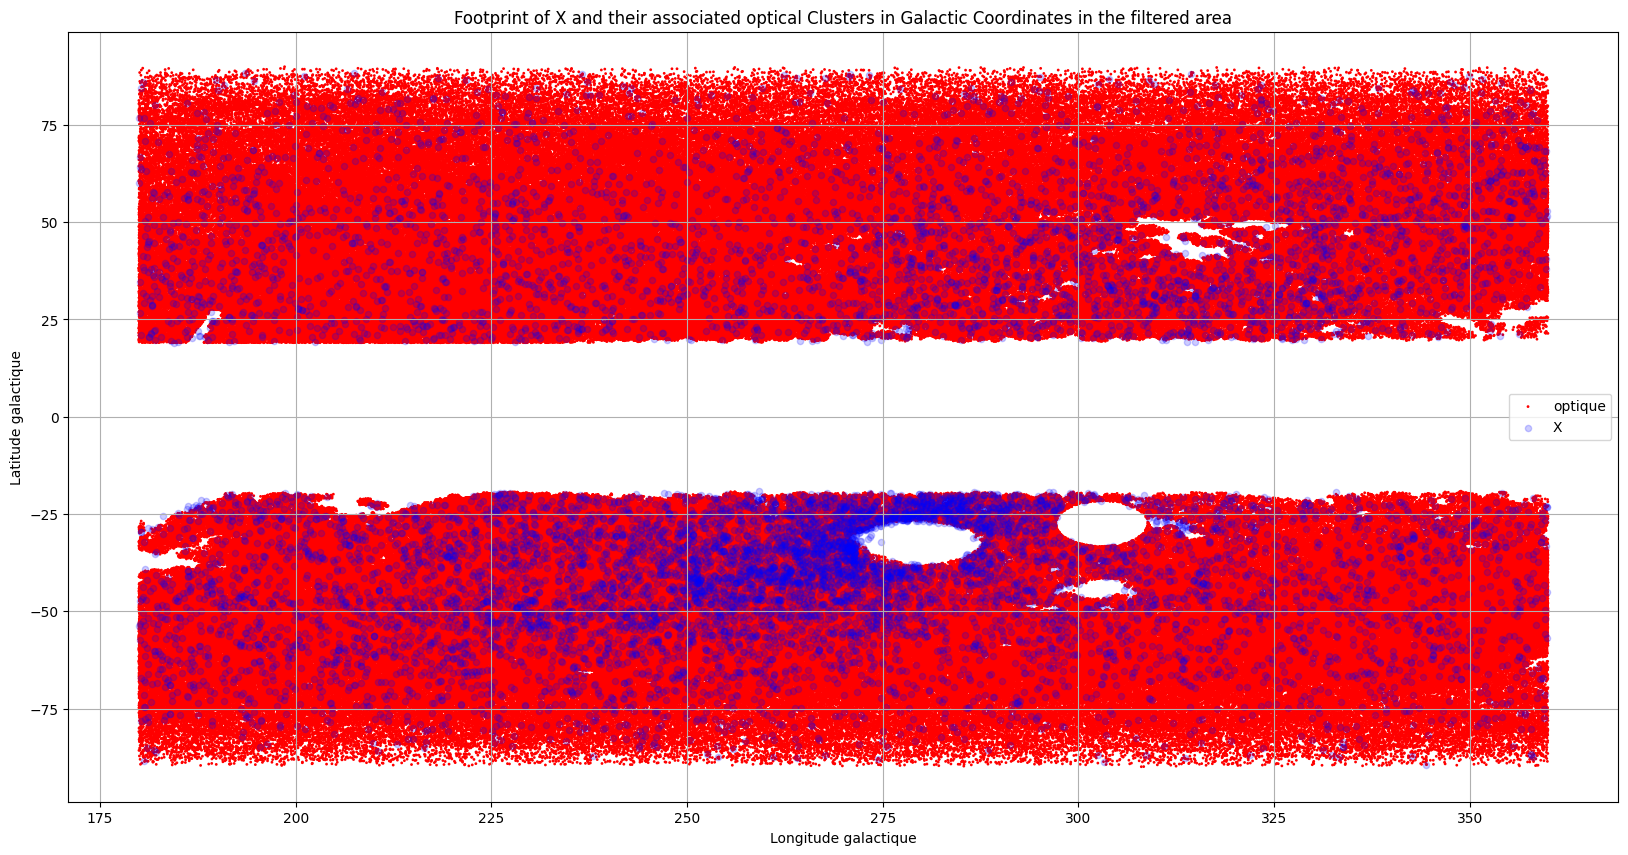

In [ ]:
opt_glon_filtered = table_optique['glon'].tolist() ; opt_glat_filtered = table_optique['glat'].tolist()
X_glon_filtered = table_X['glon'].tolist() ; X_glat_filtered = table_X['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)'''
ax_projection_X_filtered = plt.subplot(111)
ax_projection_opt_filtered = plt.subplot(111)


ax_projection_opt_filtered.scatter(opt_glon_filtered, opt_glat_filtered,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_filtered.grid(True)
ax_projection_opt_filtered.set_xlabel("Longitude galactique")
ax_projection_opt_filtered.set_ylabel("Latitude galactique")

ax_projection_X_filtered.scatter(X_glon_filtered, X_glat_filtered, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_filtered.grid(True)
ax_projection_X_filtered.set_xlabel("Longitude galactique")
ax_projection_X_filtered.set_ylabel("Latitude galactique")


plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates in the filtered area")
plt.legend()


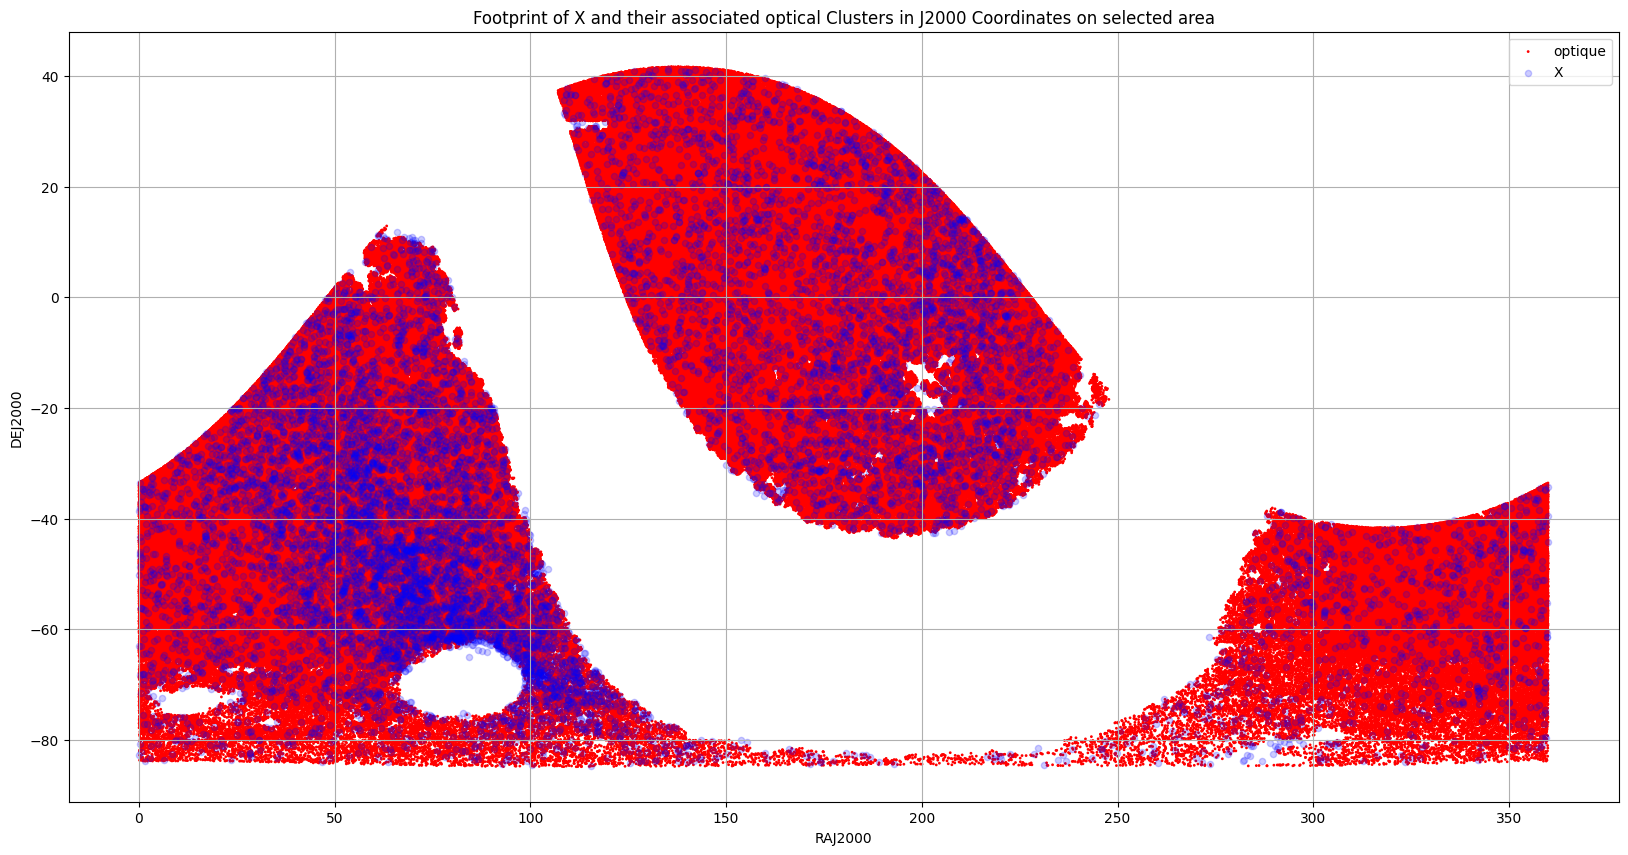

In [ ]:
# On affiche la zone sélectionnée en coordonnées J2000 

X_raj2000 = table_X['RAJ2000'].tolist() ; X_dej2000 = table_X['DEJ2000'].tolist()
opt_raj2000 = table_optique['RAJ2000'].tolist() ; opt_dej2000 = table_optique['DEJ2000'].tolist()

plt.figure(figsize=(20, 10))
ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)
ax_projection_X_all = plt.subplot(111)
ax_projection_opt_all = plt.subplot(111)


ax_projection_opt_all.scatter(opt_raj2000, opt_dej2000,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_all.grid(True)
ax_projection_opt_all.set_xlabel("RAJ2000")
ax_projection_opt_all.set_ylabel("DEJ2000")

ax_projection_X_all.scatter(X_raj2000, X_dej2000, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_all.grid(True)
ax_projection_X_all.set_xlabel("RAJ2000")
ax_projection_X_all.set_ylabel("DEJ2000") 

plt.title(f"Footprint of X and their associated optical Clusters in J2000 Coordinates on selected area")
plt.legend()


# Association

## Détermination tolérance angulaire en fonction du redshift (inspiré du code SOPHYA de Reza)

In [ ]:
'''tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)
#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )
delta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)
'''

"tolerance_ang = 30 # tolerance in arcseconds → 30 is approximately the tolerance of eROSITA instrument (we take taht into account because the X-instrument is less precise than the optical one)\n#!!! → TO DO : Faire évoluer la tolérance angulaire en foncntion de z (z ↑ => tolerance_ang ↓) : le faire par step de z : s'inspier du code de Reza (noms variables inspirés de )\ndelta_z = 0.15 # Seuil de différence de redshift (idem que dans le code de Reza → choix arbitraire ?)\n"

In [ ]:
#Paramètres asssociation

skyresol_deg = 5 # découpage du ciel en degrés, pour éviter de comparer un objet à tout les autres dans le ciel, mais seulement à ceux dans la même zone (TO DO : penser à implémenter cet aspect concrètement) 
tol_ang_fixe_arcmin = 15.0 # tolérance angulaire fixe en arcminutes → UTILITé ?
min_tol_ang_arcmin = 0.5 # tolerance angulaire plancher en arcminutes (CHOIX → eROSITA a une tolérance de 30 arcsec)
rayon_cluster_MPC = 1 # rayon du cluster (en MPC) → influence le calcule de la tolérance angulaire en fonction du redshift
delta_z = 0.010 # largeur du bin de z  (CHOIX → DESI Legacy Imaging Surveys : incertitude de 0.010 sur le z photmétrique : p.14 Wen and Han 2024)
cosmo = Planck13 # modèle cosmo utilisé : FlatLambdaCDM(name='Planck13', H0=<Quantity 67.77 km / (Mpc s)>, Om0=0.30712, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.048252)

name_indexes_crossed = 'SELECTED_0_5_arcmin__1_MPC__0_010_z.pkl' # x1 arcmin' as the minimum angular tolerance, 'x2 Mpc' as the typical cluster radius, and 'x3_z' as the redshift bin 


In [ ]:
def find_tol_ang_wrt_z(cosmo,z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg):
    
    tol_ang_variable = rayon_cluster_MPC/cosmo.angular_diameter_distance(z).value # cosmo.luminosity_distance est en MPC donc tol_ang_variable est en radian
    tol_ang = math.radians((min_tol_ang_arcmin/60)) + tol_ang_variable   # Sûr ???

    skyresol_rad = math.radians(skyresol_deg)

    if tol_ang > skyresol_rad:
        tol_ang = skyresol_rad

    tol_ang = math.degrees(tol_ang) *3600 # Convertit en secondes d'arc
    return tol_ang 

In [ ]:
find_tol_ang_wrt_z(cosmo,0.2,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg) # 0.3 est un exemple de redshift (à changer) → renvoie la tolérance angulaire en arcminutes (environ 5.0 arcminutes)

323.7813118212253

In [ ]:
find_tol_ang_wrt_z(cosmo,0.3,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)

247.7584450752764

In [ ]:
find_tol_ang_wrt_z(cosmo,0.5,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)

189.07681676402265

## Association X → optique

In [ ]:
# Détermination du nombre de bins de redshift
nb_bin_z_X = round(table_X['zBest'].max()/delta_z,0) ; nb_bin_z_opt = round(table_optique['zCl'].max()/delta_z,0)
nb_bin_z = int(max(nb_bin_z_X, nb_bin_z_opt))
print(f" On va considérer {nb_bin_z} bins de redshift ({delta_z} de large)")

 On va considérer 173 bins de redshift (0.01 de large)


In [ ]:
tol_ang_list = [] # On va y placer les tolérances angulaires pour chaque bin de redshift : on prend à chaque fois la valeur maximale du bin de redshift afin d'obtenir la tolérance angulaire la plus contraignante
for i in range(nb_bin_z):
    tol_ang_current = find_tol_ang_wrt_z(cosmo,(i+1)*delta_z,rayon_cluster_MPC,min_tol_ang_arcmin,skyresol_deg)
    tol_ang_list.append(tol_ang_current)
print(f"tol_ang_list : {tol_ang_list}")

tol_ang_list : [4750.32359081026, 2419.105693107137, 1642.1377023396024, 1253.732684176972, 1020.7532429192147, 865.486905993414, 754.6283217444411, 671.5248088872112, 606.9248729946745, 555.2776130963683, 513.0506337715783, 477.88900119844817, 448.16237333648706, 422.70621717565655, 400.66653908752966, 381.40284129626724, 364.42532900821664, 349.3530484994732, 335.88524475575736, 323.7813118212253, 312.84647161982815, 302.9213585533464, 293.87432116139854, 285.59564836695625, 277.9931814233724, 270.98893848938906, 264.5164892988984, 258.5188924017257, 252.94705918238992, 247.7584450752764, 242.9159940931266, 238.38728125652509, 234.14381094535491, 230.16043907061234, 226.41489430248384, 222.88737909372261, 219.56023540189491, 216.41766319226377, 213.44548224784475, 210.630929707861, 207.962487234614, 205.4297328706844, 203.02321356709663, 200.73433509387235, 198.55526662903551, 196.4788577923825, 194.49856627053387, 192.60839448869737, 190.80283403674915, 189.07681676402265, 187.42567

In [ ]:
# On découpe les tables en fonction des bins de redshift
table_X_list_bins = []
table_optique_list_bins = [] 

def cut_table_bins_z(table,name_z,nb_bins):
    table_bins_list = []
    for i in range(nb_bins):
        z_min = i*delta_z
        z_max = (i+1)*delta_z
        table_bins = table[(table[name_z] >= z_min) & (table[name_z] <= z_max)]
        table_bins_list.append(table_bins)
    return table_bins_list 

table_X_list_bins = cut_table_bins_z(table_X,'zBest',nb_bin_z) # On découpe la table X en fonction des bins de redshift
#table_optique_list_bins = cut_table_bins_z(table_optique,'zCl',nb_bin_z) # idem mais pour la table optique


In [ ]:
# On commence par créer des listes de coordonnées (RAJ2000,DEJ2000) en récupérant les colonnes correspondantes sur les tables

liste_indexes_X = [] # listes des indexes dans cahque bin, pour pouvoir réaliser l'association par la suite (en effet, le découpage en bin de redshift a mélangé les indices dans table_X_list_bins)
liste_coords_X = [] # Liste de coordonnées (RAJ2000,DEJ2000) pour chaque bin de redshift
for x in table_X_list_bins:
    liste_indexes_X_bin = []
    liste_coords_X_bin = []
    for index,row in x.iterrows():
        liste_indexes_X_bin.append(index) ; liste_coords_X_bin.append((row['RAJ2000'],row['DEJ2000']))
    liste_indexes_X.append(liste_indexes_X_bin) ; liste_coords_X.append(liste_coords_X_bin)

liste_coords_optique = []
for index,row in table_optique.iterrows():
    coord = (row['RAJ2000'],row['DEJ2000'])
    liste_coords_optique.append(coord)


In [ ]:
# A LANCER UNIQUEMENT POUR UN NOUVEAU SET DE PARAMETRES, dans ce cas mettre la variable RUN à True :
RUN = True

# TO DO ; trouver un moyen d'accélérer le calcul ! (voir cross_matching_X_optique _tentative_accel_calcul.ipynb)

folder = '../DESI_eRass/indexes_crossed/' # Dossier de sortie pour les indices croisés
print(name_indexes_crossed) #pour rappeler quels paramètres ont été utilisés

if RUN :
    indices_crossed = [] 
    for i in range(nb_bin_z):
        indices_crossed_current = match_celestial_objects_list_deg(liste_coords_X[i],liste_coords_optique,tol_ang_list[i])
        indices_crossed.append(indices_crossed_current) 

    with open(os.path.join(folder, name_indexes_crossed), 'wb') as file:
        pickle.dump(indices_crossed, file)

SELECTED_0.5_arcmin__1_MPC__0 010_z.pkl


In [ ]:
with open(os.path.join(folder, name_indexes_crossed), 'rb') as file:
    indices_crossed = pickle.load(file)

In [ ]:
len(indices_crossed)

173

In [ ]:
'''indices_crossed_array = np.array(indices_crossed) ; print("shape indices_crossed_array",np.shape(indices_crossed_array))
liste_indexes_X_array = np.array(liste_indexes_X) ; print("shape liste_indexes_X",np.shape(liste_indexes_X_array))
'''

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (173,) + inhomogeneous part.

In [ ]:
# Ici, on récupères les indices des objets X, conservés dans liste_indexes_X, pour remplacer ceux obtenus avec le cross-match dans indices_crossed (qui correpondent aux indices du bin dans lequels ils sont situés)
# En clair, on reproduit indices_crossed mais avec les "vraies" indices des objets X 

indices_crossed_list = []

'''for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        k = indices_crossed[i][j][0]
        if k >= len(liste_indexes_X[i]):
            print(f"Erreur: indice {k} hors limites pour le bin {i} (taille {len(liste_indexes_X[i])})")
            print(f"indices_crossed[{i}][{j}] = {indices_crossed[i][j]}")
            continue  # ou break pour stopper
'''
for i in range(nb_bin_z):
    indices_crossed_list_bin = []
    for j in range(len(indices_crossed[i])):
        indices_crossed_list_bin.append([liste_indexes_X[i][indices_crossed[i][j][0]],indices_crossed[i][j][1]]) # le "vrai" indice X remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift 
    indices_crossed_list.append(indices_crossed_list_bin)

# !!! bug !!! pour SELECTED_0.5_arcmin__1_MPC__0 010_z → 'IndexError: list index out of range' sur la ligne 8 : alors que ce n'est pas le cas pour les autres fichiers

Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3153] = (np.int64(28), np.int64(796525))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3154] = (np.int64(28), np.int64(796571))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3155] = (np.int64(28), np.int64(796594))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3156] = (np.int64(28), np.int64(796599))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3157] = (np.int64(28), np.int64(796605))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3158] = (np.int64(28), np.int64(796616))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3159] = (np.int64(28), np.int64(796719))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices_crossed[1][3160] = (np.int64(28), np.int64(796777))
Erreur: indice 28 hors limites pour le bin 1 (taille 28)
indices

'for i in range(nb_bin_z):\n    indices_crossed_list_bin = []\n    for j in range(len(indices_crossed[i])):\n        indices_crossed_list_bin.append([liste_indexes_X[i][indices_crossed[i][j][0]],indices_crossed[i][j][1]]) # le "vrai" indice X remplace celui qui permettait de le retrouver dans la liste des coordonnées par bin de redshift \n    indices_crossed_list.append(indices_crossed_list_bin)'

In [ ]:
# Ici, on récupère les indices pour chaque association, un indice X est donc répété autant de fois que ce cluster est associé à un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique,
# il y aura 3 fois l'indices du cluster A dans la liste "indices_X_crossed_repetitifs")
indices_X_crossed_repetitifs = []
indices_opt_repetitifs = []
for indices_crossed_list_bin in indices_crossed_list:
    for x in indices_crossed_list_bin :
        indices_X_crossed_repetitifs.append(x[0])
        indices_opt_repetitifs.append(x[1])

# Ici, on ne garde qu'une seule occurrence de chaque cluster X associé à au moins un cluster optique (si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice
# du cluster A dans la liste "indices_X_crossed")
number_of_duplicates = 0
indices_X_crossed = set()
for indices_crossed_list_bin in indices_crossed_list:
    for float1, float2 in indices_crossed_list_bin:
        if float1 in indices_X_crossed:
            number_of_duplicates += 1
        else:
            indices_X_crossed.add(float1)
indices_X_crossed = sorted(indices_X_crossed)
print(f"Proportion de duplicats par rapport an nombre de galaxies en X: {round(number_of_duplicates/len(table_X) * 100,3)} %")



Proportion de duplicats par rapport an nombre de galaxies en X: 498.109 %


## table_X_crossed_3D 

(Au final, on sélectionne selon la distance angulaire et on applique un seuil de z)

Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il y aura 3 fois l'indices du cluster A dans la table "table_X_crossed_repetitifs".

In [ ]:
# Il peut y avoir plusieurs occurences d'un même objet X dans cette liste
table_X_crossed_repetitifs = table_X.loc[indices_X_crossed_repetitifs]
table_X_crossed_repetitifs['__indexes'] = indices_X_crossed_repetitifs
# Reorder columns to place '__indexes' at the first position
table_X_crossed_repetitifs = table_X_crossed_repetitifs[['__indexes'] + [col for col in table_X_crossed_repetitifs.columns if col != '__indexes']]

In [ ]:
# On réindice pour que les indices correpondent à l'ordre des positions dans la table
table_X_ = table_X.reset_index(drop=True)
table_optique_ = table_optique.reset_index(drop=True)

In [ ]:
diff_z_list_repetitif = []
dist_ang_list_repetitif = []

for i in range(len(table_X_crossed_repetitifs)):
    index_X = indices_X_crossed_repetitifs[i] ; index_opt = indices_opt_repetitifs[i]

    X_row_of_interest = table_X_crossed_repetitifs[table_X_crossed_repetitifs['__indexes'] == index_X].iloc[0] #On ne sélectionne qu'une seule ligne parmi ses éventuelles occurrences

    diff_z = abs(X_row_of_interest['zBest'] - table_optique_.loc[index_opt]['zCl']) 
    diff_z_list_repetitif.append(diff_z)
    dist_ang = np.sqrt((X_row_of_interest['RAJ2000'] - table_optique_['RAJ2000'][index_opt])**2 + (X_row_of_interest['DEJ2000'] - table_optique_['DEJ2000'][index_opt])**2)
    dist_ang_list_repetitif.append(dist_ang)
    
table_X_crossed_repetitifs['id_asso_opt'] = indices_opt_repetitifs
table_X_crossed_repetitifs['diff_z'] = diff_z_list_repetitif
table_X_crossed_repetitifs['dist_ang'] = dist_ang_list_repetitif

Tout l'intéret de récupérer ce dataframe "table_X_crossed_repetitifs" est de pouvoir lui appliquer un seuil pour "diff_z" : en effet, l'association faite avec la fonction 'match_celestial_objects_list_deg' ne se basait que sur la distance angulaire entre les clusters. En appliquant ce seuil sur le redshift, on passe d'un cross-matching "2D" à "3D".

In [ ]:
# On applique le seuil de redshift pour ne conserver que les assocciations qui ne sont pas trop éloignées en redshift

table_X_crossed_3D = table_X_crossed_repetitifs[table_X_crossed_repetitifs['diff_z'] < delta_z]
print(np.round(100-(len(table_X_crossed_3D)/len(table_X_crossed_repetitifs))*100,1), " % des associations sont éliminées par le critère de redshift") 

table_optique_associated_3D = table_optique_.loc[table_X_crossed_3D['id_asso_opt']]
table_optique_associated_3D['id_asso_X'] = table_X_crossed_3D['__indexes'].tolist()

92.1  % des associations sont éliminées par le critère de redshift


In [ ]:
associations = []
for index,x in table_X_crossed_3D.iterrows():
    current_asso = [0,0]
    current_asso[0] = int(x['__indexes']) ; current_asso[1] = int(x['id_asso_opt'])
    associations.append(current_asso)

table_X_crossed_3D['id_associations'] = associations ; table_optique_associated_3D['id_associations'] = associations

C:\Users\ED282972\AppData\Local\Temp\ipykernel_17256\3693998815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_3D['id_associations'] = associations ; table_optique_associated_3D['id_associations'] = associations


In [ ]:
# Sélection zone fiduciaire (pour éviter d'avoir des objets X dont l'association optique a été précédemment filtrée ←→ séparation de couples)

seuil_fiduciaire = 1 
radius_ = radius + seuil_fiduciaire ; borne_1_glat_ = borne_1_glat - seuil_fiduciaire ; borne_2_glat_ = borne_2_glat + seuil_fiduciaire ; min_glon = min_glon + seuil_fiduciaire

table_X_crossed_3D['distance'] = np.sqrt((table_X_crossed_3D['glon'] - x_center)**2 + (table_X_crossed_3D['glat'] - y_center)**2)
table_X_crossed_3D = table_X_crossed_3D[table_X_crossed_3D['distance'] >= radius_]
table_X_crossed_3D = table_X_crossed_3D.drop(columns=['distance'])



table_X_crossed_3D = table_X_crossed_3D[(table_X_crossed_3D['glon'] > min_glon)
                                    & ((table_X_crossed_3D['glat'] <= borne_1_glat_) | (table_X_crossed_3D['glat']>= borne_2_glat_))
                                    ]
print(len(table_X_crossed_3D_))


table_optique_associated_3D = table_optique_associated_3D[table_optique_associated_3D['id_associations'].isin(table_X_crossed_3D['id_associations'].tolist())] # On ne conserve ques les associations dont les objets X sont dans la zone fiduciaire : cela permet d'éviter 
                                                                                                                                                               # la séparation de couples (si le 'seuil_fiduciaire' est assez grand)
print(len(table_optique_associated_3D_))

'''table_optique_associated_3D_ = table_optique_associated_3D_.loc[table_X_crossed_3D_['id_asso_opt']]
print(len(table_optique_associated_3D_))
table_optique_associated_3D_ = table_optique_associated_3D_[table_optique_associated_3D_['id_asso_X'].isin(table_X_crossed_3D_['__indexes'].tolist())]
print(len(table_optique_associated_3D_))'''


C:\Users\ED282972\AppData\Local\Temp\ipykernel_17256\4110135384.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_X_crossed_3D['distance'] = np.sqrt((table_X_crossed_3D['glon'] - x_center)**2 + (table_X_crossed_3D['glat'] - y_center)**2)


21520
21520


"table_optique_associated_3D_ = table_optique_associated_3D_.loc[table_X_crossed_3D_['id_asso_opt']]\nprint(len(table_optique_associated_3D_))\ntable_optique_associated_3D_ = table_optique_associated_3D_[table_optique_associated_3D_['id_asso_X'].isin(table_X_crossed_3D_['__indexes'].tolist())]\nprint(len(table_optique_associated_3D_))"

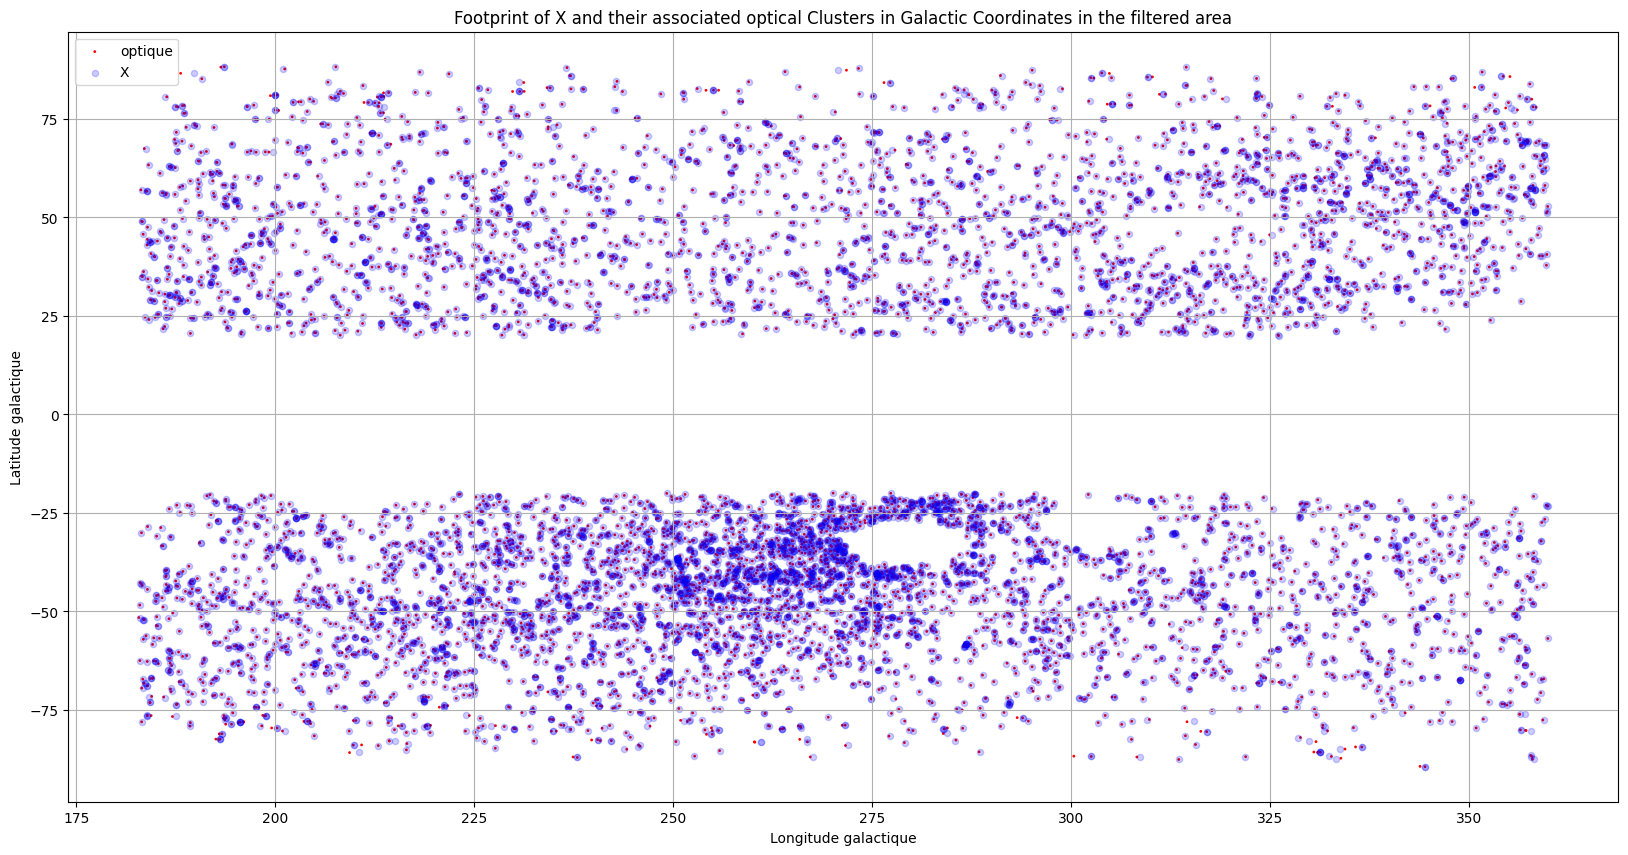

In [ ]:
opt_glon_associated_3D = table_optique_associated_3D['glon'].tolist() ; opt_glat_associated_3D = table_optique_associated_3D['glat'].tolist()
X_glon_crossed_3D = table_X_crossed_3D['glon'].tolist() ; X_glat_crossed_3D = table_X_crossed_3D['glat'].tolist()


fig = plt.figure(figsize=(20, 10))
'''ax_projection_X = plt.subplot(111)
ax_projection_opt = plt.subplot(111)'''
ax_projection_X_ = plt.subplot(111)
ax_projection_opt_ = plt.subplot(111)


ax_projection_opt_.scatter(opt_glon_associated_3D, opt_glat_associated_3D,s=1,edgecolors='red',facecolors='none',label='optique') 
ax_projection_opt_.grid(True)
ax_projection_opt_.set_xlabel("Longitude galactique")
ax_projection_opt_.set_ylabel("Latitude galactique")

ax_projection_X_.scatter(X_glon_crossed_3D, X_glat_crossed_3D, s=20,facecolors='blue',alpha=0.2,label='X') 
ax_projection_X_.grid(True)
ax_projection_X_.set_xlabel("Longitude galactique")
ax_projection_X_.set_ylabel("Latitude galactique")


plt.title(f"Footprint of X and their associated optical Clusters in Galactic Coordinates in the filtered area")
plt.legend()


## table_X_crossed [DEPRECATED] (TO DO mettre à jour avec zone fiduciaire) 
Si un cluster A détecté en X est associé à 3 clusters détectés en optique, il n'y aura tout de même qu'une seule fois l'indice du cluster A dans la table "table_X_crossed" (pas de seuil sur la différence de z, association uniquement '2D').

In [ ]:
#Pour chaque objet X, on va identifier le nombre d'objets optiques associés, aisni que les indices de ces objets optiques

associations_dict_X = {}
for x in indices_X_crossed:
    associations_dict_X[x] = []
    for i in range(nb_bin_z):
        for float1, float2 in indices_crossed_list[i]:
            if float1 == x:
                associations_dict_X[x].append(float2)

#Maintenant, on va ajouter à chaque objet X le nombre d'objets optiques associés
for x in indices_X_crossed:
    num_associations = len(associations_dict_X[x])
    associations_dict_X[x] = (associations_dict_X[x], num_associations)

#On obtient un dictionnaire de la forme {indice_X : (indices_objets_optique, nombre_objets_optique_associés)}
'''print("Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) : ",'\n' )
associations_dict_X'''
            

Format de chaque entrée du dictionnaire : (indice_x) : ((liste_indices_optiques_associées),nombres d'objets dans l'optique associé) :  



{0: ([np.int64(61),
   np.int64(946342),
   np.int64(946666),
   np.int64(946807),
   np.int64(946888)],
  5),
 1: ([np.int64(695),
   np.int64(1502),
   np.int64(942360),
   np.int64(942463),
   np.int64(943654),
   np.int64(943770),
   np.int64(946133)],
  7),
 2: ([np.int64(77),
   np.int64(192),
   np.int64(556),
   np.int64(730),
   np.int64(795),
   np.int64(796),
   np.int64(799),
   np.int64(825),
   np.int64(947),
   np.int64(1320),
   np.int64(1721),
   np.int64(1797),
   np.int64(945502),
   np.int64(945592),
   np.int64(945793),
   np.int64(945920),
   np.int64(946256),
   np.int64(946280),
   np.int64(947039)],
  19),
 3: ([np.int64(35),
   np.int64(482),
   np.int64(636),
   np.int64(839),
   np.int64(889),
   np.int64(1085),
   np.int64(1227),
   np.int64(1653),
   np.int64(946785),
   np.int64(947392)],
  10),
 4: ([np.int64(577),
   np.int64(651),
   np.int64(732),
   np.int64(784),
   np.int64(786),
   np.int64(912),
   np.int64(923),
   np.int64(1109),
   np.int64(14

Maintenant, on récupère dans la table X les objets qui ont une association :

In [ ]:
table_X_crossed = table_X.loc[indices_X_crossed] #; table_X_crossed = table_X_crossed.reset_index(drop=True) # On reset l'index pour ne pas avoir de mismacth dans les calculs par la suite
#table_optique_crossed = ta<<dble_optique.iloc[indices_optique_crossed] ; table_optique_crossed = table_optique_crossed.reset_index(drop=True)

In [ ]:
#On calcule les informations d'associations "diff_z" et "dist_ang" pour chaque objet X

diff_z_list = [] # Liste qui va contenir les différences de redshift entre l'objet X et l'ensemble des objets optiques associés
dist_ang_list = [] # Liste qui va contenir les distances angulaires entre l'objet X et l'ensemble des objets optiques associés
for index, x in table_X_crossed.iterrows():
    obj_opt_ass = associations_dict_X[index][0] #liste des objets optiques associés à l'objet X courant
    diff_z = []
    dist_ang = []
    for j in range(len(obj_opt_ass)): # On parcourt la liste des objets optiques associés à l'objet X
        diff_z.append(abs(table_X_crossed['zBest'][index] - table_optique_['zCl'][obj_opt_ass[j]]))
        dist_ang.append(np.sqrt((table_X_crossed['RAJ2000'][index] - table_optique_['RAJ2000'][obj_opt_ass[j]])**2 + (table_X_crossed['DEJ2000'][index] - table_optique_['DEJ2000'][obj_opt_ass[j]])**2)) 
    diff_z_list.append(diff_z) # On ajoute la liste des différences de redshift à la liste diff_z_list
    dist_ang_list.append(dist_ang)
    #print(f"Index: {index}, Element: {x}")
    #print(associations_dict_X[i])
    # print(associations_dict_X[index])
    #print(associations_dict_X[index][0][j])
    """diff_z.append(abs(table_X_crossed['zBest'][i] - table_optique['Z'][associations_dict_X[i][0]]))
    diff_z_list.append(diff_z)"""

In [ ]:
# On ajoute les informations d'associations à table_X_crossed. En comparaison de ce qu'a fait Reza on a : Nb_assos <-> idm ; id_assos <-> idass ; diff_z <-> delz ; dist_ang <-> dstass  

#Nb_assos :
nb_assos_list = [x[1][1] for x in associations_dict_X.items()]
table_X_crossed['nb_assos'] = nb_assos_list

#id_assos :
id_assos_list = [x[1][0] for x in associations_dict_X.items()]
table_X_crossed['id_assos'] = id_assos_list

#diff_z
table_X_crossed['diff_z'] = diff_z_list

#dist_ang
table_X_crossed['dist_ang'] = dist_ang_list


In [ ]:
# On crée la table "optique associée" en ne conservant que les objets optiques associés à un objet X

'flattened_list = [item for sublist in nested_list for item in sublist]'
id_assos_list_flatten = [id_assos for sublist in id_assos_list for id_assos in sublist] # On 'flatten' id_assos_list
table_optique_associated = table_optique.iloc[id_assos_list_flatten]

In [ ]:
# TO DO Sélection zone fiduciaire (comme pour table_X_crossed_3D) : problème ici la colonne 'id_assos' de table_X_crossed est une liste de listes

'''table_X_crossed['distance'] = np.sqrt((table_X_crossed['glon'] - x_center)**2 + (table_X_crossed['glat'] - y_center)**2)
table_X_crossed = table_X_crossed[table_X_crossed['distance'] >= radius_]
table_X_crossed = table_X_crossed.drop(columns=['distance'])



table_X_crossed = table_X_crossed[(table_X_crossed['glon'] > min_glon)
                                    & ((table_X_crossed['glat'] >= borne_1_glat_) | (table_X_crossed['glat'] <= borne_2_glat_))
                                    ]


table_optique_associated = table_optique_associated.loc[table_X_crossed['id_asso']]'''

"table_X_crossed['distance'] = np.sqrt((table_X_crossed['glon'] - x_center)**2 + (table_X_crossed['glat'] - y_center)**2)\ntable_X_crossed = table_X_crossed[table_X_crossed['distance'] >= radius_]\ntable_X_crossed = table_X_crossed.drop(columns=['distance'])\n\n\n\ntable_X_crossed = table_X_crossed[(table_X_crossed['glon'] > min_glon)\n                                    & ((table_X_crossed['glat'] >= borne_1_glat_) | (table_X_crossed['glat'] <= borne_2_glat_))\n                                    ]\n\n\ntable_optique_associated = table_optique_associated.loc[table_X_crossed['id_asso']]"

## Association optique → X (To do)

# Visualisation résultats associations 

## Histogramme diff_z

On trace les histogrammes des différences de z entre associations (pour l'instant seulement pour les assos X→optiques), pout mon code et celui de Reza.

In [ ]:
clx_catass_df_crossed = clx_catass_df[clx_catass_df['asscnt'] != 0] # éléments ayant une association dans le code de Reza (avec saminière à lui définir la tolérance anluaire → voir clxmatch.cc)

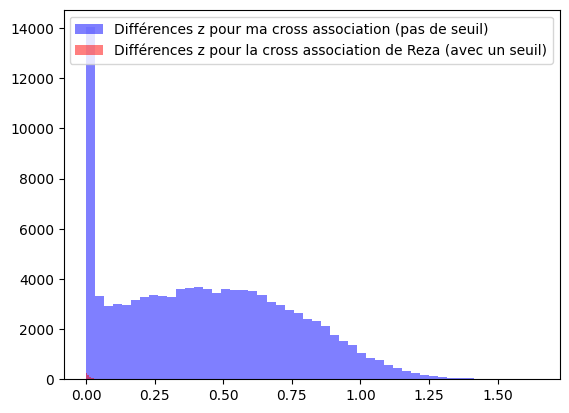

In [ ]:
# Sans seuil sur z 
diff_z_list_flatten = [item for sublist in diff_z_list for item in sublist] # On 'flatten' id_assos_list
plt.hist(diff_z_list_flatten,bins=50,label='Différences z pour ma cross association (pas de seuil)',color='blue',alpha=0.5)
plt.hist(np.abs(clx_catass_df_crossed['delz']),bins=50,label='Différences z pour la cross association de Reza (avec un seuil)',color='red',alpha=0.5)
plt.legend()

# Pourquoi il n'y a qu'un seul delz pour un objet avec plusieurs associations optiques dans clx_catass_df → seule diff_z la plus faible est prise en compte dans catass (mais il y a don d'autres diff_z 'valides'<0.15
# qui sont ignorés)

## Diagramme N-M / M-M

In [ ]:
table_X_crossed_3D

__indexes        glon       glat    _RAJ2000   _DEJ2000  \
2552       2552  209.634369 -50.384357   55.048567 -18.579460   
3833       3833  200.416033 -33.239623   67.917806  -5.084819   
4370       4370  201.358652 -27.735914   73.130685  -3.105706   
8094       8094  269.583941  26.491612  159.165881 -27.515430   
9528       9528  302.405192  21.557974  192.207279 -41.311106   
...         ...         ...        ...         ...        ...   
1457       1457  224.403605 -64.956881   41.237815 -29.211993   
4116       4116  268.699384 -39.409988   70.655392 -59.091652   
3992       3992  260.902174 -41.204962   69.513577 -52.915845   
2453       2453  194.161129 -46.370054   54.091171  -7.610755   
840         840  266.066668 -69.175450   29.755758 -42.791252   

                         Name     RAJ2000    DEJ2000         Exp   zBest  ...  \
2552  1eRASS J034011.6-183446   55.048567 -18.579460  221.399994  0.0056  ...   
3833  1eRASS J043140.2-050505   67.917806  -5.084819  146.399994  0.0160  ...   
4370  1eRASS J045231.3-030620   73.130685  -3.105706  137.600006  0.0148  ...   
8094  1eRASS J103639.8-273055  159.165881 -27.515430  104.500000  0.0114  ...   
9528  1eRASS J124849.7-411839  192.207279 -41.311106  177.699997  0.0110  ...   
...                       ...         ...        ...         ...     ...  ...   
1457  1eRASS J024457.0-291243   41.237815 -29.211993  198.300003  1.1419  ...   
4116  1eRASS J044237.2-590529   70.655392 -59.091652  773.799988  1.1687  ...   
3992  1eRASS J043803.2-525457   69.513577 -52.915845  542.099976  1.1774  ...   
2453  1eRASS J033621.8-073638   54.091171  -7.610755  276.700012  1.1828  ...   
840   1eRASS J015901.3-424728   29.755758 -42.791252  145.800003  1.2192  ...   

        KT     Mgas500   YX500       M500  Fgas500        R500  id_asso_opt  \
2552   NaN         NaN     NaN        NaN      NaN -2147483648      1065734   
3833   NaN         NaN     NaN        NaN      NaN -2147483648       329685   
4370   NaN         NaN     NaN        NaN      NaN -2147483648      1084026   
8094  3.10   74.360001  231.18  15.840000    0.047         820       530797   
9528  3.19  194.779999  623.62  26.990000    0.073         979       657419   
...    ...         ...     ...        ...      ...         ...          ...   
1457   NaN   28.910000    0.00  24.930000    0.016         621       204765   
4116   NaN   55.709999    0.00  14.770000    0.044         517       342101   
3992   NaN  232.119995    0.00  20.240000    0.115         572      1080588   
2453   NaN   95.309998    0.00  27.190001    0.039         630       265674   
840    NaN         NaN     NaN        NaN      NaN -2147483648       143248   

      diff_z  dist_ang  id_associations  
2552  0.0086  0.000999  [2552, 1065734]  
3833  0.0004  0.002128   [3833, 329685]  
4370  0.0001  0.001053  [4370, 1084026]  
8094  0.0021  0.017430   [8094, 530797]  
9528  0.0045  0.317038   [9528, 657419]  
...      ...       ...              ...  
1457  0.0021  0.057199   [1457, 204765]  
4116  0.0045  0.146979   [4116, 342101]  
3992  0.0044  0.012338  [3992, 1080588]  
2453  0.0016  0.048685   [2453, 265674]  
840   0.0068  0.046332    [840, 143248]  

[8168 rows x 29 columns]

In [ ]:
table_optique_associated_3D

glon       glat   _RAJ2000  _DEJ2000       ID n_Name  \
1065734  209.635642 -50.383836   55.04938 -18.58004  1065735          
329685   200.416500 -33.241710   67.91617  -5.08618   329686    WH-   
1084026  201.358589 -27.736965   73.12974  -3.10617  1084027    WH-   
530797   269.571465  26.480843  159.14868 -27.51825   530798    WH-   
657419   302.655197  21.489060  192.51630 -41.38195   657420    WH-   
...             ...        ...        ...       ...      ...    ...   
204765   224.412923 -65.006728   41.18091 -29.21778   204766    WH-   
342101   268.730199 -39.330220   70.79654 -59.13264   342102    WH-   
1080588  260.915480 -41.199667   69.51971 -52.92655  1080589    WH-   
265674   194.187647 -46.415009   54.06232  -7.64997   265675    WH-   
143248   266.170848 -69.180995   29.71560 -42.81436   143249    WH-   

                     Name    RAJ2000   DEJ2000     zCl  ...  lam500  M500  \
1065734  J034011.9-183448   55.04938 -18.58004  0.0142  ...   25.88  11.8   
329685   J043139.9-050510   67.91617  -5.08618  0.0156  ...   12.46   5.8   
1084026  J045231.1-030622   73.12974  -3.10617  0.0147  ...   10.86   5.1   
530797   J103635.7-273106  159.14868 -27.51825  0.0135  ...   21.93  10.0   
657419   J125003.9-412255  192.51630 -41.38195  0.0155  ...   38.90  17.5   
...                   ...        ...       ...     ...  ...     ...   ...   
204765   J024443.4-291304   41.18091 -29.21778  1.1398  ...   11.02   5.1   
342101   J044311.2-590758   70.79654 -59.13264  1.1732  ...   11.01   5.1   
1080588  J043804.7-525536   69.51971 -52.92655  1.1818  ...   24.00  10.9   
265674   J033615.0-073900   54.06232  -7.64997  1.1844  ...   12.67   5.9   
143248   J015851.7-424852   29.71560 -42.81436  1.2124  ...   10.11   4.7   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  id_asso_X  \
1065734     6    0.0      0.0      2  CFSFDP     1065735       2552   
329685      9    0.0      0.0      1              329686       3833   
1084026     9    0.0      0.0      2             1084027       4370   
530797     20    0.0      0.0      1              530798       8094   
657419     23    0.0      0.0      1              657420       9528   
...       ...    ...      ...    ...        ...      ...        ...   
204765      7    0.0      0.0      1              204766       1457   
342101      6    0.0      0.0      1              342102       4116   
1080588     9    0.0      0.0      2             1080589       3992   
265674      6    0.0      0.0      1              265675       2453   
143248      6    0.0      0.0      1              143249        840   

         id_associations  
1065734  [2552, 1065734]  
329685    [3833, 329685]  
1084026  [4370, 1084026]  
530797    [8094, 530797]  
657419    [9528, 657419]  
...                  ...  
204765    [1457, 204765]  
342101    [4116, 342101]  
1080588  [3992, 1080588]  
265674    [2453, 265674]  
143248     [840, 143248]  

[8168 rows x 25 columns]

In [ ]:
index_optique_associated_3D = table_optique_associated_3D.index.tolist()
table_optique_associated_3D['__indexes'] = index_optique_associated_3D
table_optique_associated_3D = table_optique_associated_3D[['__indexes'] + [col for col in table_optique_associated_3D.columns if col != '__indexes']]
table_optique_associated_3D

C:\Users\ED282972\AppData\Local\Temp\ipykernel_17256\3880711562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_optique_associated_3D['__indexes'] = index_optique_associated_3D


__indexes        glon       glat   _RAJ2000  _DEJ2000       ID  \
1065734    1065734  209.635642 -50.383836   55.04938 -18.58004  1065735   
329685      329685  200.416500 -33.241710   67.91617  -5.08618   329686   
1084026    1084026  201.358589 -27.736965   73.12974  -3.10617  1084027   
530797      530797  269.571465  26.480843  159.14868 -27.51825   530798   
657419      657419  302.655197  21.489060  192.51630 -41.38195   657420   
...            ...         ...        ...        ...       ...      ...   
204765      204765  224.412923 -65.006728   41.18091 -29.21778   204766   
342101      342101  268.730199 -39.330220   70.79654 -59.13264   342102   
1080588    1080588  260.915480 -41.199667   69.51971 -52.92655  1080589   
265674      265674  194.187647 -46.415009   54.06232  -7.64997   265675   
143248      143248  266.170848 -69.180995   29.71560 -42.81436   143249   

        n_Name              Name    RAJ2000   DEJ2000  ...  lam500  M500  \
1065734         J034011.9-183448   55.04938 -18.58004  ...   25.88  11.8   
329685     WH-  J043139.9-050510   67.91617  -5.08618  ...   12.46   5.8   
1084026    WH-  J045231.1-030622   73.12974  -3.10617  ...   10.86   5.1   
530797     WH-  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0   
657419     WH-  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5   
...        ...               ...        ...       ...  ...     ...   ...   
204765     WH-  J024443.4-291304   41.18091 -29.21778  ...   11.02   5.1   
342101     WH-  J044311.2-590758   70.79654 -59.13264  ...   11.01   5.1   
1080588    WH-  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9   
265674     WH-  J033615.0-073900   54.06232  -7.64997  ...   12.67   5.9   
143248     WH-  J015851.7-424852   29.71560 -42.81436  ...   10.11   4.7   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  id_asso_X  \
1065734     6    0.0      0.0      2  CFSFDP     1065735       2552   
329685      9    0.0      0.0      1              329686       3833   
1084026     9    0.0      0.0      2             1084027       4370   
530797     20    0.0      0.0      1              530798       8094   
657419     23    0.0      0.0      1              657420       9528   
...       ...    ...      ...    ...        ...      ...        ...   
204765      7    0.0      0.0      1              204766       1457   
342101      6    0.0      0.0      1              342102       4116   
1080588     9    0.0      0.0      2             1080589       3992   
265674      6    0.0      0.0      1              265675       2453   
143248      6    0.0      0.0      1              143249        840   

         id_associations  
1065734  [2552, 1065734]  
329685    [3833, 329685]  
1084026  [4370, 1084026]  
530797    [8094, 530797]  
657419    [9528, 657419]  
...                  ...  
204765    [1457, 204765]  
342101    [4116, 342101]  
1080588  [3992, 1080588]  
265674    [2453, 265674]  
143248     [840, 143248]  

[8168 rows x 26 columns]

In [ ]:
# Quantités intéressantes
N_gal = table_optique_associated_3D['Ngal']
richness = table_optique_associated_3D['lam500'] # Richness : mass proxy → define eq 2 in Wen 2024
M_500_opt = np.array(table_optique_associated_3D['M500'])
M500_X = np.array(table_X_crossed_3D['M500'])

In [ ]:
# Dossier où stocker les plots
folder_plots = f"../DESI_eRass/figures/{name_indexes_crossed}/"
os.makedirs(folder_plots, exist_ok=True)

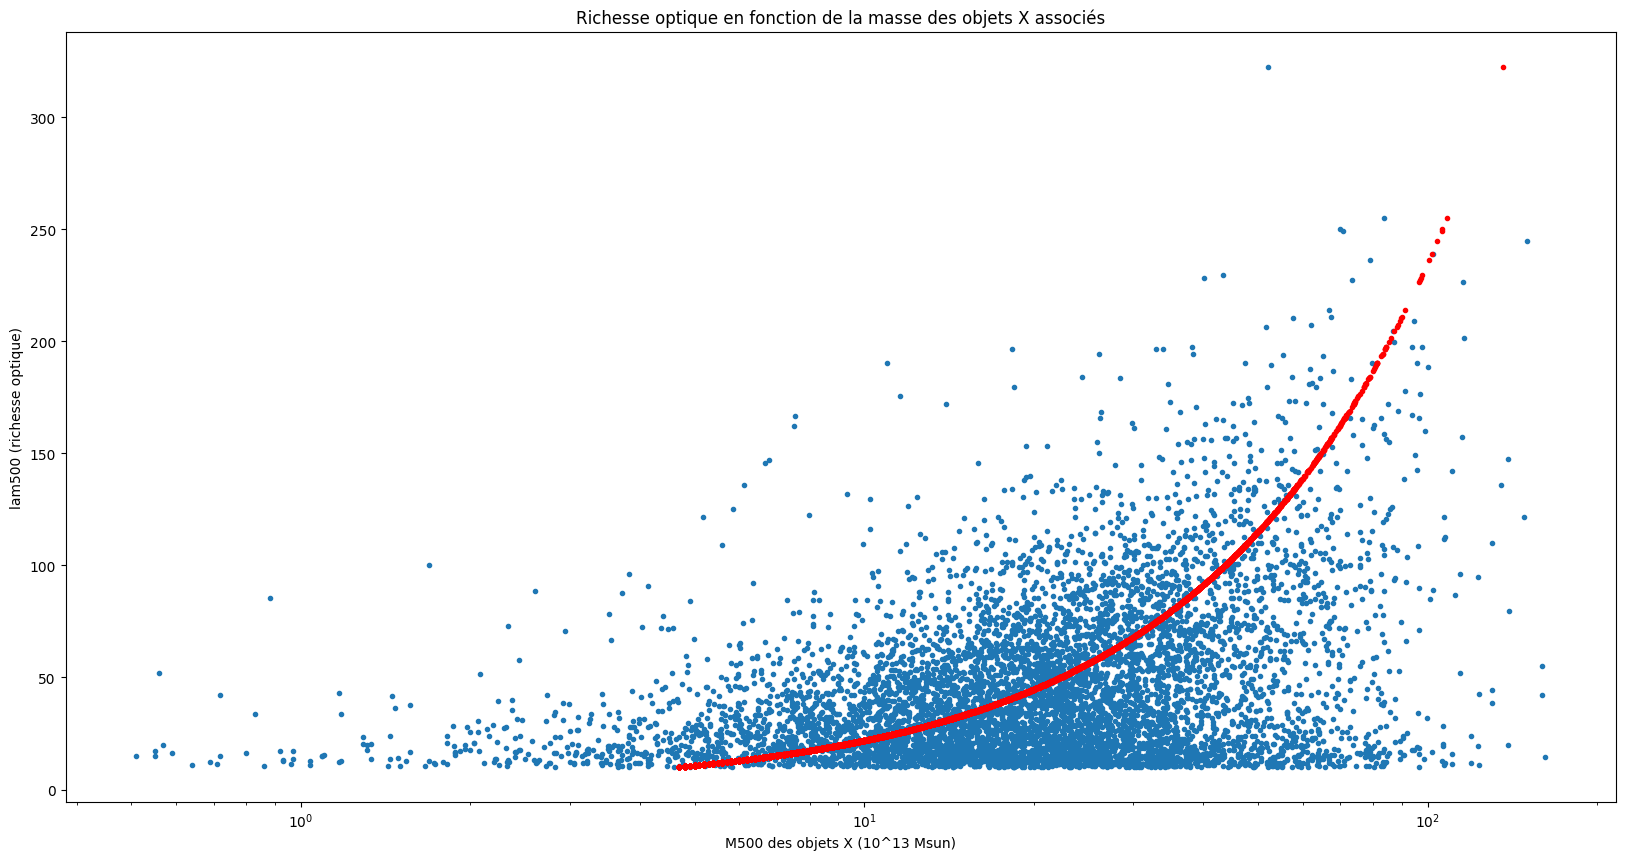

In [ ]:
# graphe richess optique - M500


plt.figure(figsize=(20, 10))
plt.plot(M500_X, richness, 'o', markersize=3,label='objets X')
plt.plot(M_500_opt, richness, 'o', color='red', markersize=3),label='objets optiques')
plt.xlabel('M500 (10^13 Msun)')
plt.ylabel('lam500 (richesse optique)')
plt.title('Richesse optique en fonction de la masse des objets X associés')
plt.xscale('log')
plt.legend()

'''output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

'output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")\nplt.savefig(output_path, dpi=300)'

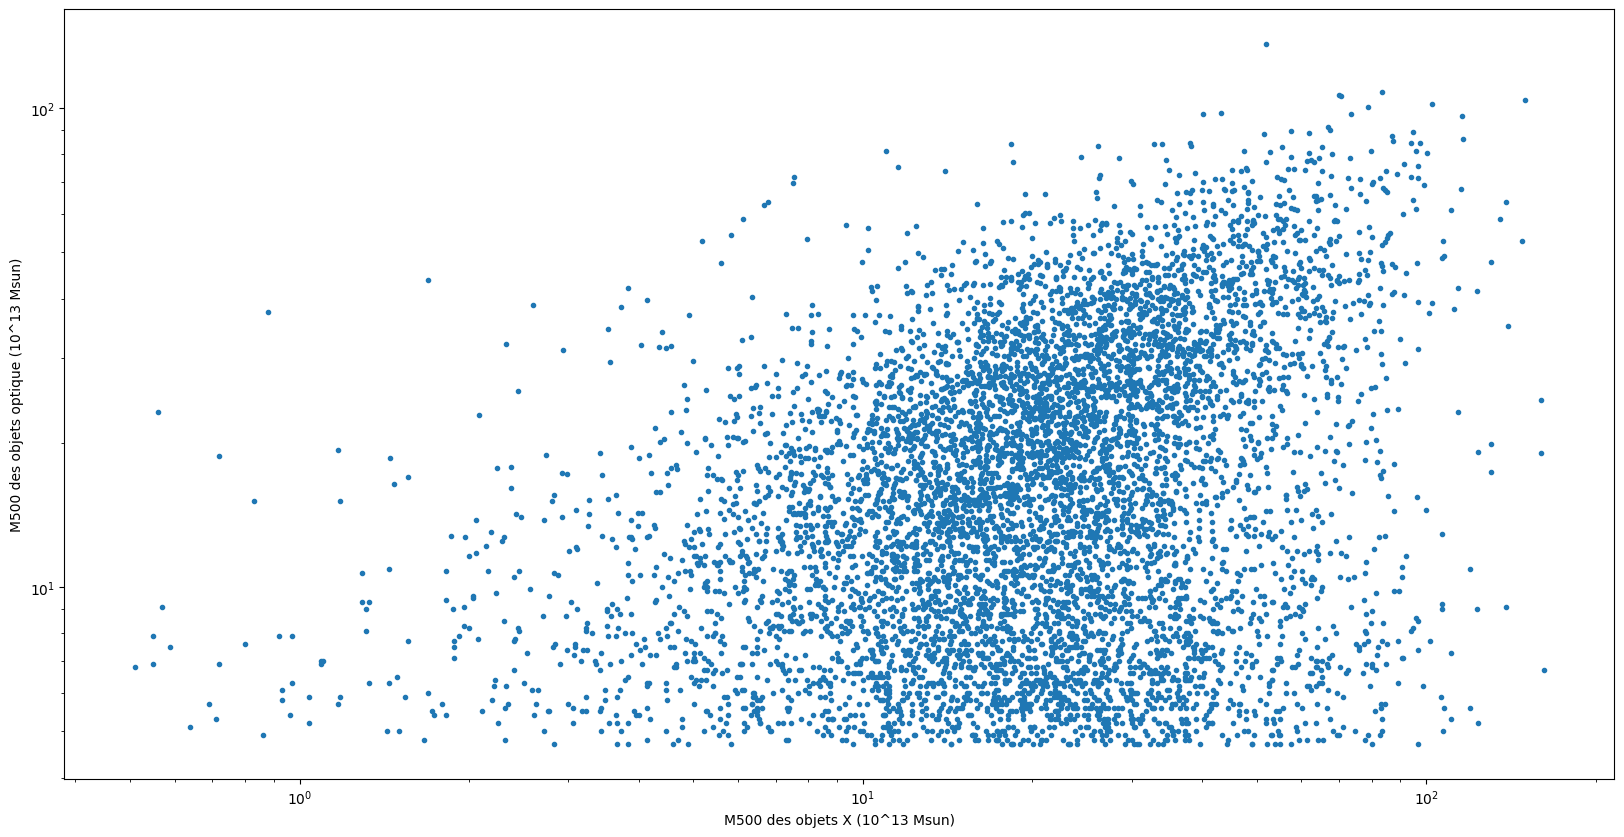

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(M500_X, M_500_opt, 'o', markersize=3)
plt.xlabel('M500 des objets X (10^13 Msun)')
plt.ylabel('M500 des objets optique (10^13 Msun)')
plt.xscale('log')
plt.yscale('log')
'''output_path = os.path.join(folder_plots, "richesse_optique_vs_M500.png")
plt.savefig(output_path, dpi=300)'''

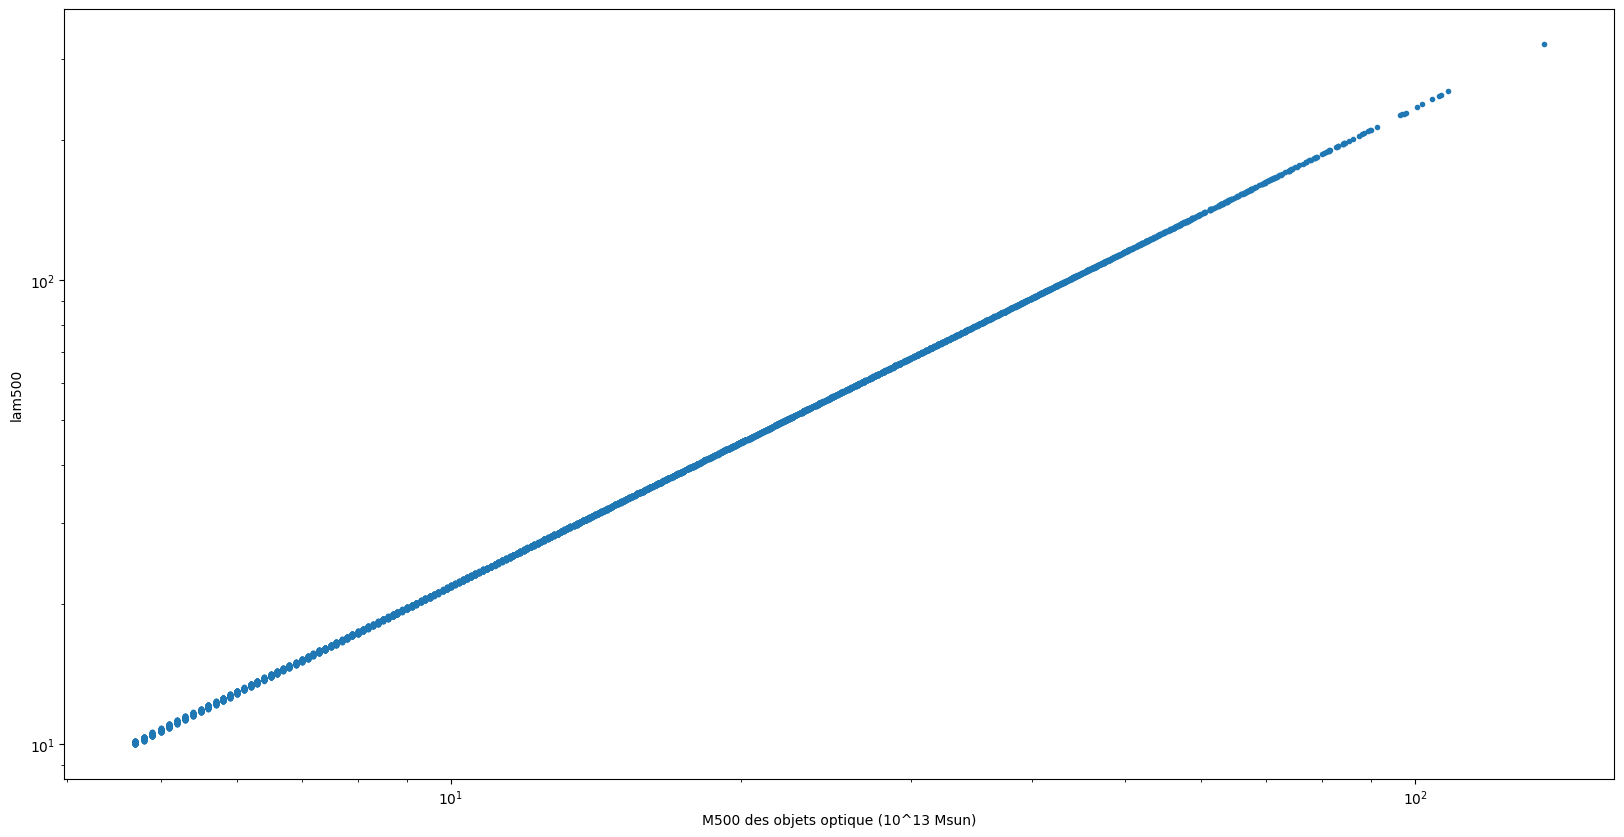

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(M_500_opt, richness, 'o', markersize=3)
plt.xlabel('M500 des objets optique (10^13 Msun)')
plt.ylabel('lam500')
plt.xscale('log')
plt.yscale('log')

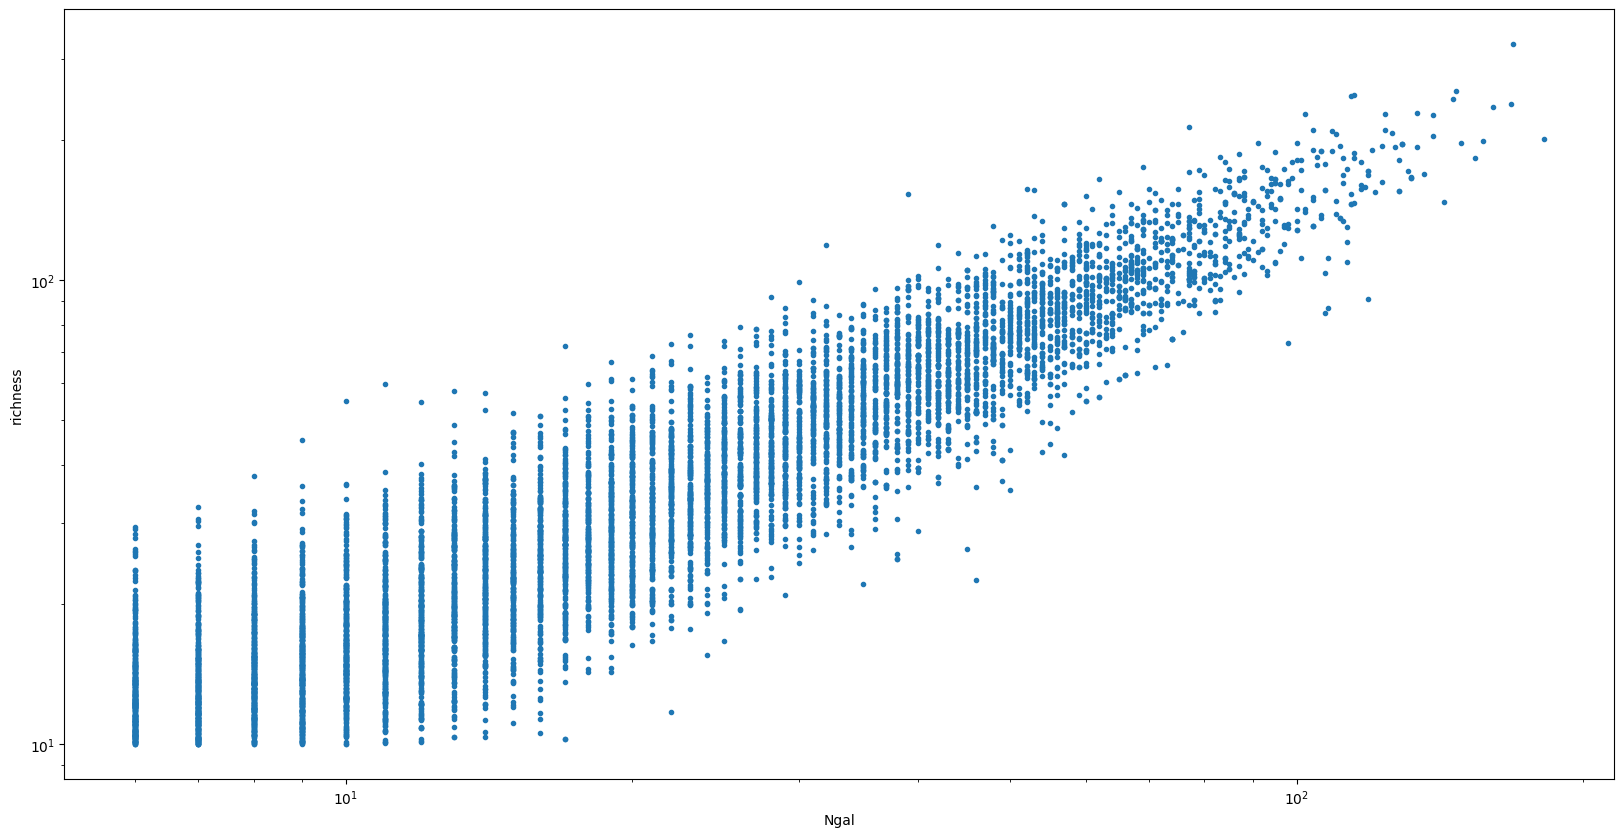

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(N_gal, richness, 'o', markersize=3)
plt.xlabel('Ngal')
plt.ylabel('richness')
plt.xscale('log')
plt.yscale('log')

In [ ]:
table_optique_associated_3D

__indexes        glon       glat   _RAJ2000  _DEJ2000       ID  \
1065734    1065734  209.635642 -50.383836   55.04938 -18.58004  1065735   
329685      329685  200.416500 -33.241710   67.91617  -5.08618   329686   
1084026    1084026  201.358589 -27.736965   73.12974  -3.10617  1084027   
530797      530797  269.571465  26.480843  159.14868 -27.51825   530798   
657419      657419  302.655197  21.489060  192.51630 -41.38195   657420   
...            ...         ...        ...        ...       ...      ...   
204765      204765  224.412923 -65.006728   41.18091 -29.21778   204766   
342101      342101  268.730199 -39.330220   70.79654 -59.13264   342102   
1080588    1080588  260.915480 -41.199667   69.51971 -52.92655  1080589   
265674      265674  194.187647 -46.415009   54.06232  -7.64997   265675   
143248      143248  266.170848 -69.180995   29.71560 -42.81436   143249   

        n_Name              Name    RAJ2000   DEJ2000  ...  lam500  M500  \
1065734         J034011.9-183448   55.04938 -18.58004  ...   25.88  11.8   
329685     WH-  J043139.9-050510   67.91617  -5.08618  ...   12.46   5.8   
1084026    WH-  J045231.1-030622   73.12974  -3.10617  ...   10.86   5.1   
530797     WH-  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0   
657419     WH-  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5   
...        ...               ...        ...       ...  ...     ...   ...   
204765     WH-  J024443.4-291304   41.18091 -29.21778  ...   11.02   5.1   
342101     WH-  J044311.2-590758   70.79654 -59.13264  ...   11.01   5.1   
1080588    WH-  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9   
265674     WH-  J033615.0-073900   54.06232  -7.64997  ...   12.67   5.9   
143248     WH-  J015851.7-424852   29.71560 -42.81436  ...   10.11   4.7   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  id_asso_X  \
1065734     6    0.0      0.0      2  CFSFDP     1065735       2552   
329685      9    0.0      0.0      1              329686       3833   
1084026     9    0.0      0.0      2             1084027       4370   
530797     20    0.0      0.0      1              530798       8094   
657419     23    0.0      0.0      1              657420       9528   
...       ...    ...      ...    ...        ...      ...        ...   
204765      7    0.0      0.0      1              204766       1457   
342101      6    0.0      0.0      1              342102       4116   
1080588     9    0.0      0.0      2             1080589       3992   
265674      6    0.0      0.0      1              265675       2453   
143248      6    0.0      0.0      1              143249        840   

         id_associations  
1065734  [2552, 1065734]  
329685    [3833, 329685]  
1084026  [4370, 1084026]  
530797    [8094, 530797]  
657419    [9528, 657419]  
...                  ...  
204765    [1457, 204765]  
342101    [4116, 342101]  
1080588  [3992, 1080588]  
265674    [2453, 265674]  
143248     [840, 143248]  

[8168 rows x 26 columns]

(array([1120., 2362., 1740., 1259.,  975.,  398.,  202.,   87.,   17.,
           8.]),
 array([0.0135 , 0.13339, 0.25328, 0.37317, 0.49306, 0.61295, 0.73284,
        0.85273, 0.97262, 1.09251, 1.2124 ]),
 <BarContainer object of 10 artists>)

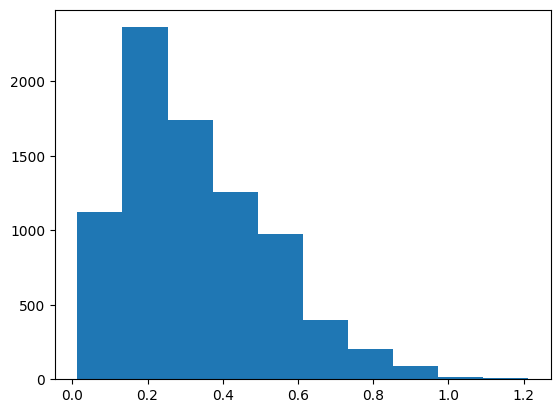

In [ ]:
plt.hist(table_optique_associated_3D['zCl'])

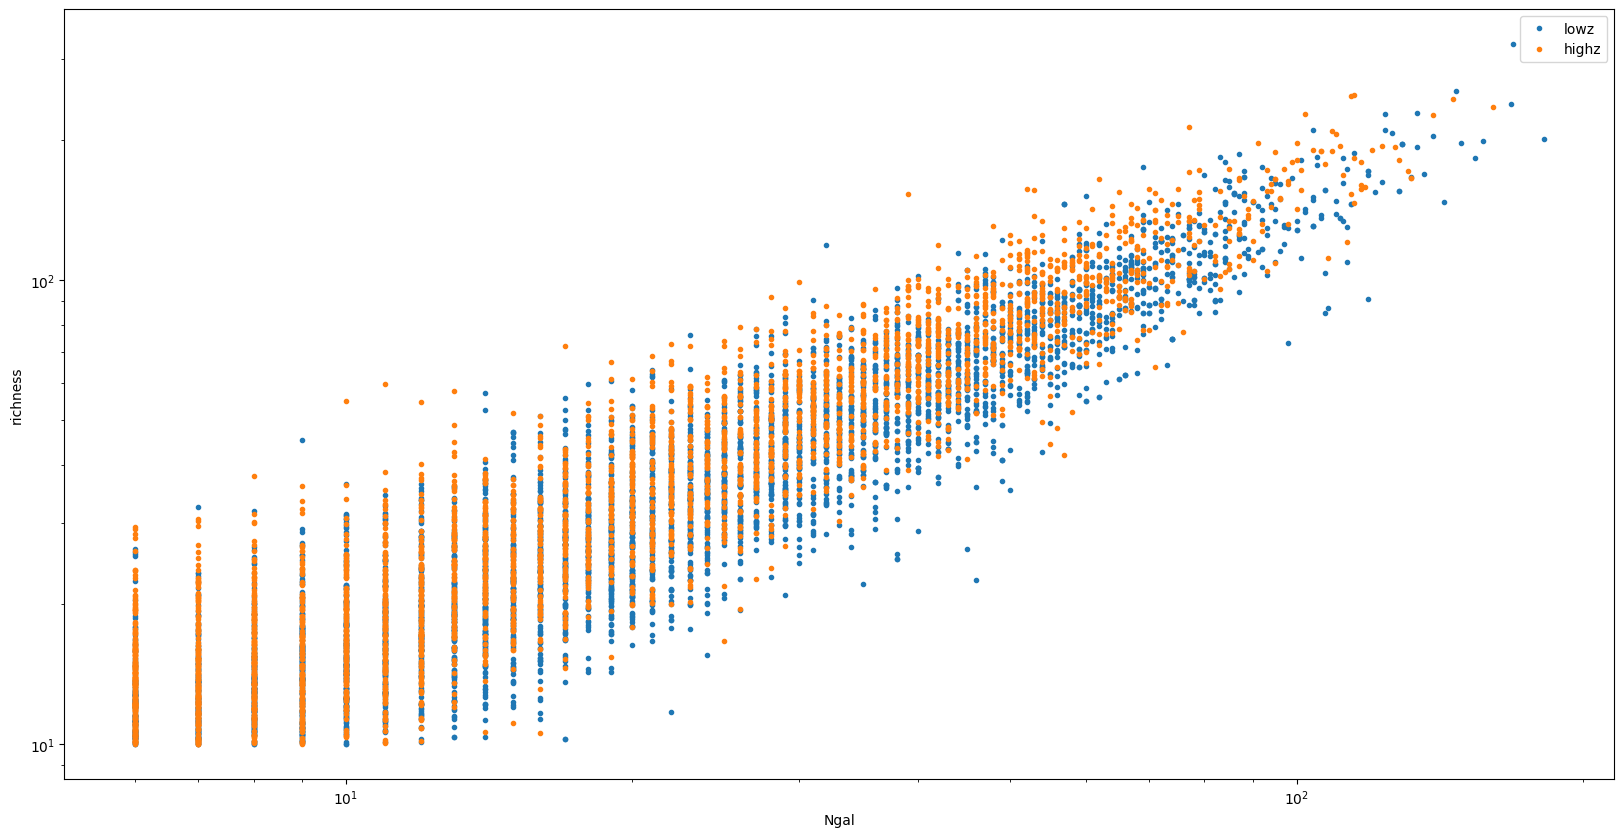

In [ ]:
table_optique_associated_3D_low_z = table_optique_associated_3D[table_optique_associated_3D['zCl']<0.35]
table_optique_associated_3D_high_z = table_optique_associated_3D[table_optique_associated_3D['zCl']>0.35]


N_gal_low_z = table_optique_associated_3D_low_z['Ngal']
richness_low_z = table_optique_associated_3D_low_z['lam500']

N_gal_high_z = table_optique_associated_3D_high_z['Ngal']
richness_high_z = table_optique_associated_3D_high_z['lam500']


plt.figure(figsize=(20, 10))
plt.plot(N_gal_low_z, richness_low_z, 'o', markersize=3,label='lowz')
plt.plot(N_gal_high_z, richness_high_z, 'o', markersize=3,label='highz')
plt.xlabel('Ngal')
plt.ylabel('richness')
plt.xscale('log')
plt.yscale('log')
plt.legend()

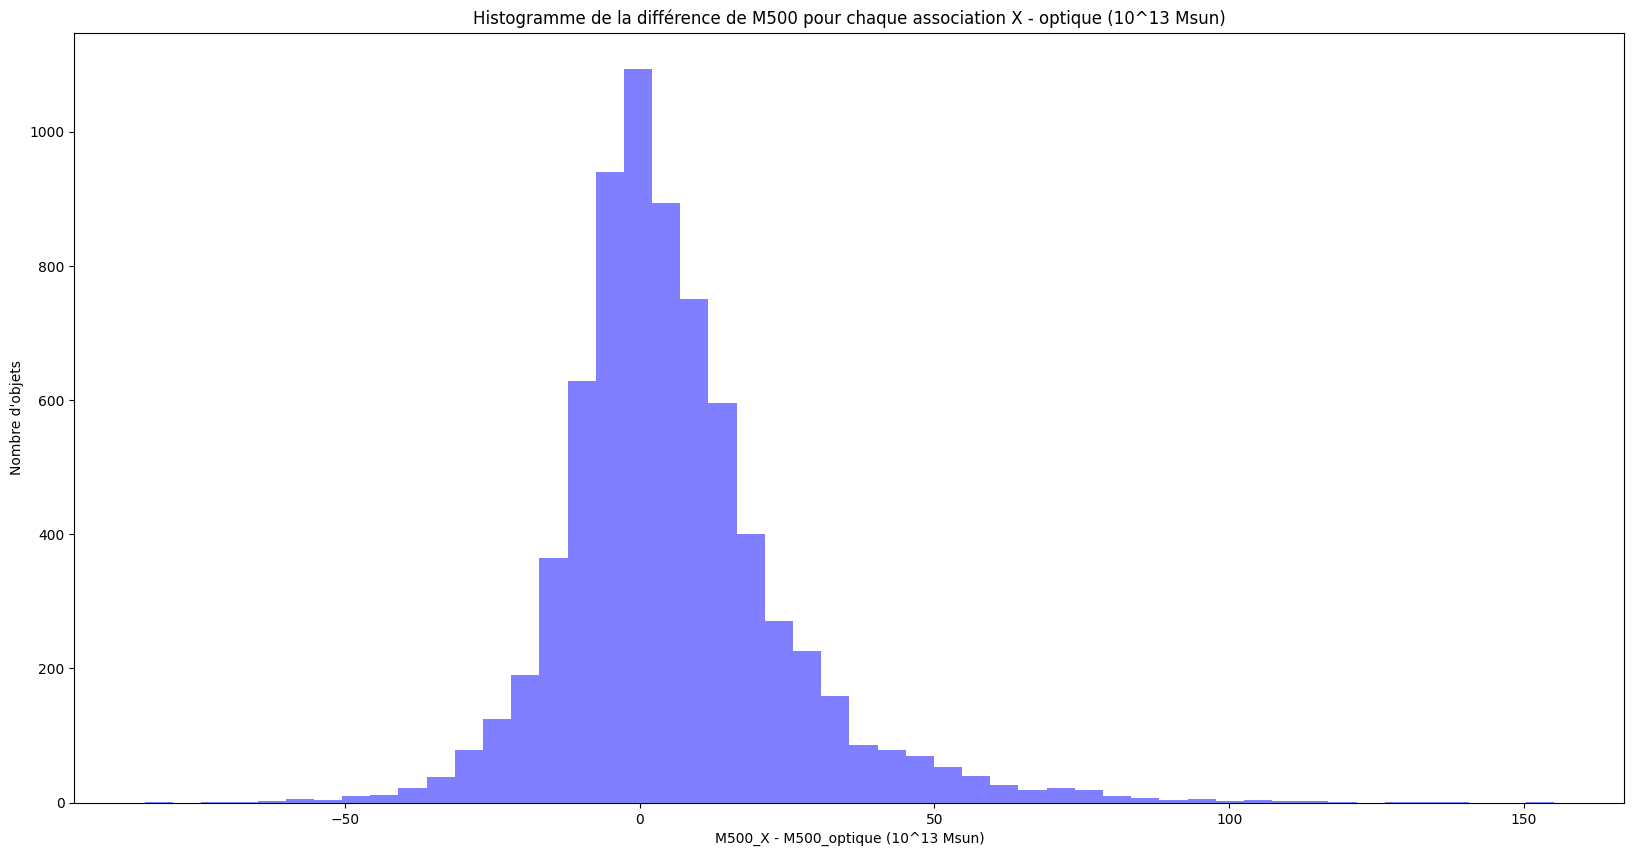

In [ ]:
# Histogramme M500_X - M500_optique
diff_mass = M500_X - M_500_opt

plt.figure(figsize=(20, 10))
plt.hist(diff_mass, bins=50, color='blue', alpha=0.5)
plt.xlabel('M500_X - M500_optique (10^13 Msun)')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun)')

output_path = os.path.join(folder_plots, "histogramme_diff_M500.png")
plt.savefig(output_path, dpi=300)

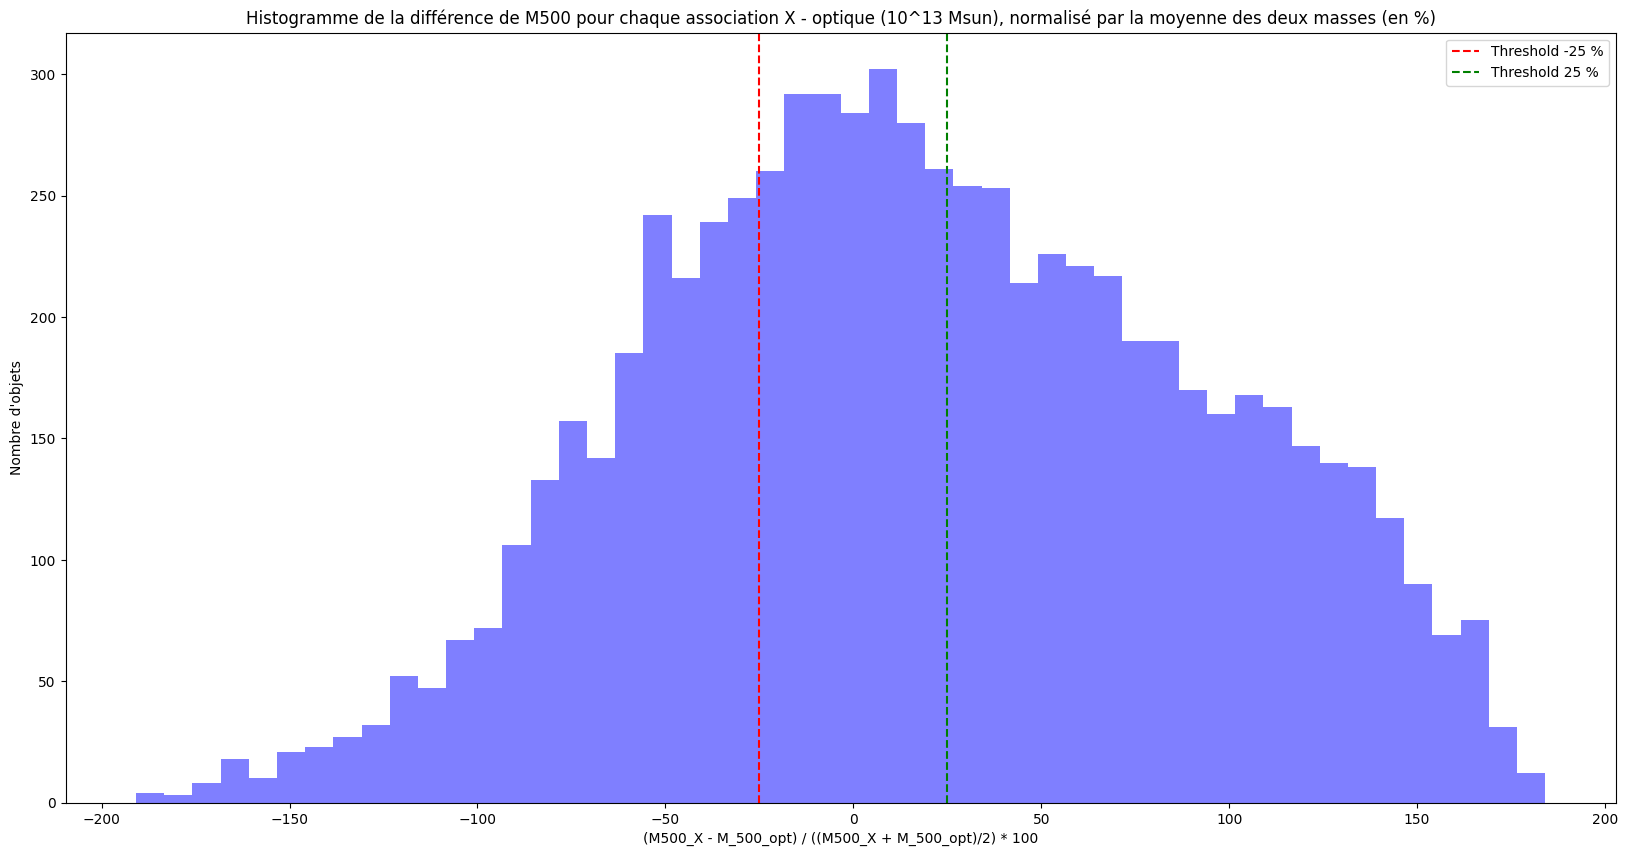

In [ ]:
diff_mass_normalisée = ((M500_X - M_500_opt) / ((M500_X + M_500_opt)/2))*100


plt.figure(figsize=(20, 10))
plt.hist(diff_mass_normalisée , bins=50, color='blue', alpha=0.5)

# Add thresholds
threshold1 = -25  # Example threshold
threshold2 = 25   # Example threshold
plt.axvline(x=threshold1, color='red', linestyle='--', label=f'Threshold {threshold1} %')
plt.axvline(x=threshold2, color='green', linestyle='--', label=f'Threshold {threshold2} %')

plt.xlabel('(M500_X - M_500_opt) / ((M500_X + M_500_opt)/2) * 100')
plt.ylabel('Nombre d\'objets')
plt.title('Histogramme de la différence de M500 pour chaque association X - optique (10^13 Msun), normalisé par la moyenne des deux masses (en %)')

plt.legend()

output_path = os.path.join(folder_plots, "histogramme_diff_M500_normalisée.png")
plt.savefig(output_path, dpi=300)

In [ ]:
# on récupère les indices des associations dont la différence de masse normalisée est supérieure à 25% (en valeur absolue)
suspect_associations_mass = []
for i in range(len(diff_mass_normalisée)):
    if abs(diff_mass_normalisée[i]) > 25:
        suspect_associations_mass.append(i)

suspect_associations_mass_indexes = np.zeros((len(suspect_associations_mass), 2))  # Initialize a 2D array with zeros
i = 0
for x in suspect_associations_mass:
    suspect_associations_mass_indexes[i][0] = table_X_crossed_3D.iloc[x].name
    suspect_associations_mass_indexes[i][1] = table_optique_associated_3D.iloc[x].name
    i += 1
suspect_associations_mass_indexes
suspect_associations_mass_indexes_X = suspect_associations_mass_indexes[:,0].astype(int)
suspect_associations_mass_indexes_opt = suspect_associations_mass_indexes[:,1].astype(int)

output_proportion_associations_suspectes = f"Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : {round(len(suspect_associations_mass)/len(diff_mass_normalisée)*100,3)} %"
print(output_proportion_associations_suspectes)

output_path = os.path.join(folder_plots, 'proportion_associations_suspectes.txt')
with open(output_path, 'w') as f:
    f.write(output_proportion_associations_suspectes)

Proportion d'associations suspectes en termes de différences de masse par rapport au nombre total d'associations : 65.952 %


In [ ]:
suspect_associations_mass_indexes
table_X_crossed_3D_suspect = table_X_crossed_3D.loc[suspect_associations_mass_indexes_X] # On récupère les objets X des associations suspectes
table_optique_associated_3D_suspect = table_optique_associated_3D.loc[suspect_associations_mass_indexes_opt] # On récupère les objets optiques des associations suspectes

In [ ]:
table_X_crossed_3D_suspect

__indexes        glon       glat    _RAJ2000   _DEJ2000  \
8094        8094  269.583941  26.491612  159.165881 -27.515430   
9528        9528  302.405192  21.557974  192.207279 -41.311106   
10418      10418  349.732797  65.498244  210.700883   9.338199   
219          219  306.170637 -60.907988   10.032887 -56.149109   
407          407  293.107098 -70.845207   17.476610 -45.929117   
...          ...         ...        ...         ...        ...   
11648      11648  337.381518 -40.221721  316.517336 -58.740395   
1457        1457  224.403605 -64.956881   41.237815 -29.211993   
4116        4116  268.699384 -39.409988   70.655392 -59.091652   
3992        3992  260.902174 -41.204962   69.513577 -52.915845   
2453        2453  194.161129 -46.370054   54.091171  -7.610755   

                          Name     RAJ2000    DEJ2000         Exp   zBest  \
8094   1eRASS J103639.8-273055  159.165881 -27.515430  104.500000  0.0114   
9528   1eRASS J124849.7-411839  192.207279 -41.311106  177.699997  0.0110   
10418  1eRASS J140248.2+092017  210.700883   9.338199  151.199997  0.0197   
219    1eRASS J004007.8-560856   10.032887 -56.149109  143.399994  0.0282   
407    1eRASS J010954.3-455544   17.476610 -45.929117  115.199997  0.0238   
...                        ...         ...        ...         ...     ...   
11648  1eRASS J210604.1-584425  316.517336 -58.740395   98.300003  1.1263   
1457   1eRASS J024457.0-291243   41.237815 -29.211993  198.300003  1.1419   
4116   1eRASS J044237.2-590529   70.655392 -59.091652  773.799988  1.1687   
3992   1eRASS J043803.2-525457   69.513577 -52.915845  542.099976  1.1774   
2453   1eRASS J033621.8-073638   54.091171  -7.610755  276.700012  1.1828   

       ...    KT      Mgas500   YX500       M500  Fgas500  R500  id_asso_opt  \
8094   ...  3.10    74.360001  231.18  15.840000    0.047   820       530797   
9528   ...  3.19   194.779999  623.62  26.990000    0.073   979       657419   
10418  ...  1.13     0.570000    1.26   0.510000    0.014   260       716173   
219    ...  1.45    60.000000   90.41  10.870000    0.055   719        43648   
407    ...  2.35    90.449997  216.31  13.420000    0.067   773        80768   
...    ...   ...          ...     ...        ...      ...   ...          ...   
11648  ...   NaN  1137.420044    0.00  73.830002    0.153   898       827613   
1457   ...   NaN    28.910000    0.00  24.930000    0.016   621       204765   
4116   ...   NaN    55.709999    0.00  14.770000    0.044   517       342101   
3992   ...   NaN   232.119995    0.00  20.240000    0.115   572      1080588   
2453   ...   NaN    95.309998    0.00  27.190001    0.039   630       265674   

             diff_z  dist_ang  id_associations  
8094   2.100000e-03  0.017430   [8094, 530797]  
9528   4.500000e-03  0.317038   [9528, 657419]  
10418  6.258480e-11  0.003607  [10418, 716173]  
219    7.000005e-04  0.182781     [219, 43648]  
407    1.999999e-03  0.005288     [407, 80768]  
...             ...       ...              ...  
11648  4.800023e-03  0.007115  [11648, 827613]  
1457   2.099943e-03  0.057199   [1457, 204765]  
4116   4.500020e-03  0.146979   [4116, 342101]  
3992   4.400007e-03  0.012338  [3992, 1080588]  
2453   1.599945e-03  0.048685   [2453, 265674]  

[8020 rows x 29 columns]

In [ ]:
table_optique_associated_3D_suspect

__indexes        glon       glat   _RAJ2000  _DEJ2000       ID  \
530797      530797  269.571465  26.480843  159.14868 -27.51825   530798   
657419      657419  302.655197  21.489060  192.51630 -41.38195   657420   
716173      716173  349.740923  65.499498  210.70262   9.34136   716174   
43648        43648  305.964340 -60.851501   10.20370 -56.21416    43649   
80768        80768  293.098323 -70.842500   17.48150 -45.93113    80769   
...            ...         ...        ...        ...       ...      ...   
827613      827613  337.373813 -40.222681  316.52188 -58.74587   827614   
204765      204765  224.412923 -65.006728   41.18091 -29.21778   204766   
342101      342101  268.730199 -39.330220   70.79654 -59.13264   342102   
1080588    1080588  260.915480 -41.199667   69.51971 -52.92655  1080589   
265674      265674  194.187647 -46.415009   54.06232  -7.64997   265675   

        n_Name              Name    RAJ2000   DEJ2000  ...  lam500  M500  \
530797     WH-  J103635.7-273106  159.14868 -27.51825  ...   21.93  10.0   
657419     WH-  J125003.9-412255  192.51630 -41.38195  ...   38.90  17.5   
716173          J140248.6+092029  210.70262   9.34136  ...   14.76   6.8   
43648           J004048.9-561251   10.20370 -56.21416  ...   15.92   7.3   
80768           J010955.6-455552   17.48150 -45.93113  ...   40.61  18.2   
...        ...               ...        ...       ...  ...     ...   ...   
827613          J210605.3-584445  316.52188 -58.74587  ...   34.87  15.7   
204765     WH-  J024443.4-291304   41.18091 -29.21778  ...   11.02   5.1   
342101     WH-  J044311.2-590758   70.79654 -59.13264  ...   11.01   5.1   
1080588    WH-  J043804.7-525536   69.51971 -52.92655  ...   24.00  10.9   
265674     WH-  J033615.0-073900   54.06232  -7.64997  ...   12.67   5.9   

         Ngal  Gamma  e_Gamma  imag_        Cat    recno  id_asso_X  \
530797     20   0.00     0.00      1              530798       8094   
657419     23   0.00     0.00      1              657420       9528   
716173     14   0.00     0.00      1  CFSFDP      716174      10418   
43648      11   0.00     0.00      1  CFSFDP       43649        219   
80768      30   0.38     0.03      1  CFSFDP       80769        407   
...       ...    ...      ...    ...        ...      ...        ...   
827613     20   0.00     0.00      1  WH22        827614      11648   
204765      7   0.00     0.00      1              204766       1457   
342101      6   0.00     0.00      1              342102       4116   
1080588     9   0.00     0.00      2             1080589       3992   
265674      6   0.00     0.00      1              265675       2453   

         id_associations  
530797    [8094, 530797]  
657419    [9528, 657419]  
716173   [10418, 716173]  
43648       [219, 43648]  
80768       [407, 80768]  
...                  ...  
827613   [11648, 827613]  
204765    [1457, 204765]  
342101    [4116, 342101]  
1080588  [3992, 1080588]  
265674    [2453, 265674]  

[5913 rows x 26 columns]